In [1]:
from __future__ import absolute_import
import os
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
# torch.multiprocessing.set_sharing_strategy('file_system')
import torch.nn.functional as F
import utils.utility as utility
from utils.logger import Logger
from torchvision.models import resnet18
from data.Camelyon import Camelyon
import argparse
from importlib import import_module
from utils.utility import adjust_learning_rate
import ssl
%tb
# ssl._create_default_https_context = ssl._create_unverified_context

from torch.utils.data import DataLoader
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
### task, config ,CV， log_dir(de-confounded backbone)， load_path(old-backbone), 
### load, resume
def parse_args():
    parser = argparse.ArgumentParser(description='Fighting~!!!')
    parser.add_argument("--task", type=str, default="Digest",
                        help="Which task to perform",
                        choices=["Digest", "Camelyon", "Nctcrc", "CausalDigest"])
    parser.add_argument('--config', type=str, default='DigestSegFull',
                        help="Config file to use.",
                        choices=["DigestSegEMCAV2", "DigestSeg", 'DigestSegPB',
                                 'DigestSegTOPK', 'DigestSegFull', 'DigestSegRCE'])
###
    parser.add_argument("--cv", type=int, default=0, 
                        help="Cross-validation folder")
    parser.add_argument("--log_dir", type=str,
                        default="/remote-home/ltc/HisMIL/experiments/Full_2class/2021_6_7",
                        help="The experiment log directory")
###
    parser.add_argument("--data_root", "-d", type=str,
                        default="/remote-home/share/DATA/HISMIL/5_folder",
                        help="root directory of data used")
    parser.add_argument("--resume", type=int, default=-1, help="Resume epoch")
    parser.add_argument("--bs", type=int, default=32, help="Resume epoch")
    parser.add_argument("--backbone", type=str, default='res18',
                        help="which backbone to use.")
    parser.add_argument("--pretrained", action="store_true", default=False,
                        help="Whether to use weighted BCE loss")
    parser.add_argument('-lr', type=float, default=1e-3, help="Learning rate")
    parser.add_argument("--epochs", "-e", type=int, default=50,
                        help="How many epochs to train")
    parser.add_argument('--cos', action='store_true', default=True,
                        help='use cosine lr schedule')
    parser.add_argument('--schedule', default=[120, 160], nargs='*', type=int,
                        help='learning rate schedule (when to drop lr by 10x)')
    # one-stage or two stage training
    parser.add_argument("--database", action="store_true", default=True, 
                        help="Using database")
    parser.add_argument('--workers', default=8, type=int, metavar='N',
                        help='number of data loading workers (default: 32)')
###load for confounder
    parser.add_argument("--load", type=int, default=-1, help="the epoch to be loaded")
###
    parser.add_argument("--load_path", type=str,
                        default="/remote-home/ltc/HisMIL/experiments/Full_2class/2021_6_7",
                        help="For confounder")
#     parser.add_argument("--load_path", type=str,
#                         default="/remote-home/ltc/HisMIL/experiments/BagDis/6.16/",
#                         help="The load directory")
    # EM
    parser.add_argument("--mmt", type=float, default=0.9, help="mmt")
    parser.add_argument("--noisy", action="store_true", default=False, help="Noisy bag pos ratio")

    # ssl
    parser.add_argument("--ssl", action="store_true", default=False, help="Self supervised learning")
    parser.add_argument("--camelyon", action="store_true", default=False, help="Training on camelyon")
    parser.add_argument("--pickle", action="store_true", default=False, help="Using pickle")
#     args = parser.parse_args()
    args = parser.parse_args(['-lr', '1e-3'])
    return args

#############################
args = parse_args()
args.log_dir = os.path.join(args.log_dir, 'f'+ str(args.cv))
args.data_root = os.path.join(args.data_root, str(args.cv))
args.load_path = os.path.join(args.load_path,'f'+ str(args.cv))
if args.task == 'Digest':
    configs = getattr(import_module('configs.' + 'DigestSeg'), 'Config')(args)
elif args.task == 'Camelyon':
    configs = getattr(import_module('configs.' + 'Camelyon'), 'Config')(args)
elif args.task == 'CausalDigest':
    configs = getattr(import_module('configs.'+'CausalDigest'), 'Config')(args) 
elif args.task == 'CausalConcat':
    configs = getattr(import_module('configs.'+'CausalConcat'), 'Config')(args)
else:
    raise NotImplementedError
tester = configs.tester
tester.backbone = tester.logger.load_backbone(tester.backbone, global_step=50)
tester.clsnet = tester.logger.load_clsnet(tester.clsnet, global_step=50)

No traceback available to show.


------------------------------------------------------------



==> Resuming net of epoch /remote-home/ltc/HisMIL/experiments/Full_2class/2021_6_7/f0/ckp/net.ckpt50.pth
set()
==> Resuming net of epoch /remote-home/ltc/HisMIL/experiments/Full_2class/2021_6_7/f0/ckp/net.ckpt50.pth
set()


In [2]:
args.cv, args.resume

(0, -1)

In [7]:
def eval_first(self, gs, trainset):
    self.backbone.eval()
    self.clsnet.eval()
    bag_idx_list = []
#     inner_idx_list = []
    feature_list = []
#     attention_list=[]
#     label_list=[]
#     TE_list = []
#     NIE_list = []
#     NDE_list = []
#     TDE_a1_list = []
#     TDE_a2_list = []
#     TDE_a3_list = []
#     TDE_a4_list = []
#     TDE_a5_list = []
#     TDE_a6_list = []
#     TDE_a7_list = []
#     TDE_a8_list = []
#     TDE_a9_list = []
#     alpha=0.3
    
    with torch.no_grad():
        for batch_idx, (imgs, instance_labels, bag_index, inner_index, nodule_ratios, real_ins_labels) in enumerate(
                tqdm(self.test_loader, ascii=True, ncols=60)):
            feature = self.backbone(imgs.to(self.device))
            bag_idx_list.append(bag_index.cpu().detach())
            feature_list.append(feature)
    # calculating mean feature
    features = torch.cat(feature_list)
    bag_idxs = torch.cat(bag_idx_list)
    return features, bag_idxs
tester.eval_first = eval_first
features, bag_idxs =tester.eval_first(tester, configs.load, configs.valset)
import torch.nn as nn
feature_tensor = []
for i in range(bag_idxs.max()):
    feature_tensor.append(features[bag_idxs==i].mean(0).unsqueeze(0))
feature_tensor = torch.cat(feature_tensor)
feature_tensor = nn.functional.normalize(feature_tensor, dim=1)
        


100%|#####################| 193/193 [00:20<00:00, 10.33it/s]


In [39]:
def cls_report_(self, y_pred, y_true, prefix=""):
    """
    A combination of sklearn.metrics function and our logger (use tensorboard)

    """
    ##make hard prediction
    y_pred_hard = [(x > 0.5) for x in y_pred]
    cls_report = classification_report(y_true, y_pred_hard, output_dict=True)
    print(cls_report)
    auc_score = roc_auc_score(y_true, y_pred)
    print(confusion_matrix(y_true, y_pred_hard))
    
def cal_preds_in_training(self, preds_tensor, bag_index_tensor, labels_tensor, epoch):
        bag_pos_ratio = torch.stack(self.trainset.bag_pos_ratios).squeeze(-1)
        y_pred_hard = [(x > 0.5) for x in preds_tensor]
        labels_tensor = labels_tensor.numpy()
        cls_report = classification_report(labels_tensor, y_pred_hard,digits=4, output_dict=False)
        auc_score = roc_auc_score(labels_tensor, preds_tensor.numpy())
        print('AUC:', auc_score)
        print(cls_report)
        print(confusion_matrix(labels_tensor, np.array(y_pred_hard)))
        # print(bag_index_tensor.max() + 1)
        # e mean predictions of bags
        bag_pred_ratio = torch.stack(
            [preds_tensor[bag_index_tensor == i].mean() for i in range(bag_index_tensor.max() + 1)])
        # the mean predictions of positive instance of bags
        bag_pos_pred_mean = torch.stack(
            [preds_tensor[bag_index_tensor == i].squeeze(1)[labels_tensor[bag_index_tensor == i] == 1].mean()
             for i in range(bag_index_tensor.max() + 1)])
        # the mean predictions of negative instance of bags
        bag_neg_pred_mean = torch.stack(
            [preds_tensor[bag_index_tensor == i].squeeze(1)[labels_tensor[bag_index_tensor == i] == 0].mean()
             for i in range(bag_index_tensor.max() + 1)])
        # the predictions of positive instance of bags
        bag_pos_pred = [
            preds_tensor[bag_index_tensor == i].squeeze(1)[labels_tensor[bag_index_tensor == i] == 1]
            for i in range(bag_index_tensor.max() + 1)]
        # the predictions of negative instance of bags
        bag_neg_pred = [
            preds_tensor[bag_index_tensor == i].squeeze(1)[labels_tensor[bag_index_tensor == i] == 0]
            for i in range(bag_index_tensor.max() + 1)]
        # expand the mean predictions of bags as bag_pos_pred
        bag_pred_ratio_pos = torch.cat(
            [preds_tensor[bag_index_tensor == i].mean().expand_as(bag_pos_pred[i]) for i in
             range(bag_index_tensor.max() + 1)])
        # expand the mean predictions of bags as bag_neg_pred
        bag_pred_ratio_neg = torch.cat(
            [preds_tensor[bag_index_tensor == i].mean().expand_as(bag_neg_pred[i]) for i in
             range(bag_index_tensor.max() + 1)])
        bag_pos_pred = torch.cat(bag_pos_pred)
        bag_neg_pred = torch.cat(bag_neg_pred)


        x = bag_pred_ratio.cpu().numpy()  # mean preds
        y = bag_pos_pred_mean.cpu().numpy()  # mean preds of pos
        z = bag_neg_pred_mean.cpu().numpy()  # mean preds of neg
        w = bag_pos_ratio.cpu().numpy()  # pos ratio
        x_neg = x[bag_pos_ratio == 0]
        x = x[bag_pos_ratio != 0]
        y = y[bag_pos_ratio != 0]
        z = z[bag_pos_ratio != 0]
        w = w[bag_pos_ratio != 0]
        
        plt.figure()
        plt.scatter(x, y, label='Pos')
        plt.scatter(x, z, label='Neg', color="green")
        plt.scatter(x_neg, x_neg, label='NNeg', color='black')
        plt.legend()
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        if not os.path.exists(os.path.join(self.logger.logdir, 'preds_figs')):
            os.makedirs(os.path.join(self.logger.logdir, 'preds_figs'))
        plt.show()
        plt.close()
def eval_(self, gs, trainset):
    # self.backbone = self.logger.load_backbone_fromold(self.backbone, global_step=gs)
    # self.clsnet = self.logger.load_clsnet_fromold(self.clsnet, global_step=gs)
#     if gs != -1:
#         print('Loading')
#         self.backbone = self.logger.load_backbone(self.backbone, global_step=gs)
#         self.clsnet = self.logger.load_clsnet(self.clsnet, global_step=gs)
    self.backbone.eval()
    self.old_backbone.eval()
    self.clsnet.eval()
#     val_loader = DataLoader(trainset, args.bs, shuffle=True, num_workers=4)
    #     confoundSet = torch.randn([trainset.__len__(), 514]
    bag_idx_list = []
    inner_idx_list = []
    feature_list = []
    attention_list=[]
    label_list=[]
    TE_list = []
    NIE_list = []
    NDE_list = []
    TDE_a1_list = []
    TDE_a2_list = []
    TDE_a3_list = []
    TDE_a4_list = []
    TDE_a5_list = []
    TDE_a6_list = []
    TDE_a7_list = []
    TDE_a8_list = []
    TDE_a9_list = []
    
    alpha=0.3
    feature_list = []
    
    with torch.no_grad():
        for batch_idx, (imgs, instance_labels, bag_index, inner_index, nodule_ratios, real_ins_labels) in enumerate(
                tqdm(self.test_loader, ascii=True, ncols=60)):
            feature = self.backbone(imgs.to(self.device))
            bag_idx_list.append(bag_index.cpu().detach())
            feature_list.append(feature)
    # calculating mean feature
    features = np.cat(feature_list)
    bag_idxs = torch.cat(bag_idx_list)
    num_bag = max(bag_idx_list)
    for i in num_bag:
        select_id = bag_idxs[bag_idxs==i]
        
    with torch.no_grad():
        for batch_idx, (imgs, instance_labels, bag_index, inner_index, nodule_ratios, real_ins_labels) in enumerate(
                tqdm(self.test_loader, ascii=True, ncols=60)):
            instance_preds, attention = self.clsnet(self.backbone(imgs.to(self.device)),
                                                                                bag_index, inner_index,
                                                                     self.old_backbone, 
                                                                     imgs.to(self.device),
                                                            a=alpha,
                                                               b=1)
            if alpha==0:
                TE_list.append(instance_preds.cpu().detach())
            else:
                TE_list.append(instance_preds[0].cpu().detach())
                NIE_list.append(instance_preds[1].cpu().detach())
                NDE_list.append(instance_preds[2].cpu().detach())
                TDE_a1_list.append(instance_preds[3].cpu().detach())
                TDE_a2_list.append(instance_preds[4].cpu().detach())
                TDE_a3_list.append(instance_preds[5].cpu().detach())
                TDE_a4_list.append(instance_preds[6].cpu().detach())
                TDE_a5_list.append(instance_preds[7].cpu().detach())
                TDE_a6_list.append(instance_preds[8].cpu().detach())
                TDE_a7_list.append(instance_preds[9].cpu().detach())
                TDE_a8_list.append(instance_preds[10].cpu().detach())
                TDE_a9_list.append(instance_preds[11].cpu().detach())
            attention_list.append(attention)
            
            inner_idx_list.append(inner_index.cpu().detach())
            label_list.append(real_ins_labels.cpu().detach())
            print('label', real_ins_labels[0])

#     return feature_list, 
    return attention_list,bag_idx_list, inner_idx_list, label_list,NDE_list,TE_list,\
                NIE_list,\
                NDE_list,\
                TDE_a1_list,\
                TDE_a2_list,\
                TDE_a3_list,\
                TDE_a4_list,\
                TDE_a5_list,\
                TDE_a6_list,\
                TDE_a7_list,\
                TDE_a8_list,\
                TDE_a9_list

tester.eval = eval_
tester.cls_report = cls_report_
tester.cal_preds_in_training = cal_preds_in_training
tester.trainset=configs.testset
attention_list,bag_idx_list, inner_idx_list, label_list,NDE_list,TE_list,\
                NIE_list,\
                NDE_list,\
                TDE_a1_list,\
                TDE_a2_list,\
                TDE_a3_list,\
                TDE_a4_list,\
                TDE_a5_list,\
                TDE_a6_list,\
                TDE_a7_list,\
                TDE_a8_list,\
                TDE_a9_list = tester.eval(tester, configs.load, configs.valset)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
bag_index_tensor = torch.cat(bag_idx_list)
labels_tensor = torch.cat(label_list)
TE_tensor = torch.cat(TE_list)
NIE_tensor = torch.cat(NIE_list)
NDE_tensor = torch.cat(NDE_list)
TDE_a1_tensor = torch.cat(TDE_a1_list)
TDE_a2_tensor = torch.cat(TDE_a2_list)
TDE_a3_tensor = torch.cat(TDE_a3_list)
TDE_a4_tensor = torch.cat(TDE_a4_list)
TDE_a5_tensor = torch.cat(TDE_a5_list)
TDE_a6_tensor = torch.cat(TDE_a6_list)
TDE_a7_tensor = torch.cat(TDE_a7_list)
TDE_a8_tensor = torch.cat(TDE_a8_list)
TDE_a9_tensor = torch.cat(TDE_a9_list)
import torch.nn as nn
softmax = nn.Softmax(dim=1)

In [3]:
def cls_report_(self, y_pred, y_true, prefix=""):
    """
    A combination of sklearn.metrics function and our logger (use tensorboard)

    """
    ##make hard prediction
    y_pred_hard = [(x > 0.5) for x in y_pred]
    cls_report = classification_report(y_true, y_pred_hard, output_dict=True)
    print(cls_report)
    auc_score = roc_auc_score(y_true, y_pred)
    print(confusion_matrix(y_true, y_pred_hard))
    
def cal_preds_in_training(self, preds_tensor, bag_index_tensor, labels_tensor, epoch):
        bag_pos_ratio = torch.stack(self.trainset.bag_pos_ratios).squeeze(-1)
        y_pred_hard = [(x > 0.5) for x in preds_tensor]
        labels_tensor = labels_tensor.numpy()
        cls_report = classification_report(labels_tensor, y_pred_hard,digits=4, output_dict=False)
        auc_score = roc_auc_score(labels_tensor, preds_tensor.numpy())
        print('AUC:', auc_score)
        print(cls_report)
        print(confusion_matrix(labels_tensor, np.array(y_pred_hard)))
        # print(bag_index_tensor.max() + 1)
        # e mean predictions of bags
        bag_pred_ratio = torch.stack(
            [preds_tensor[bag_index_tensor == i].mean() for i in range(bag_index_tensor.max() + 1)])
        # the mean predictions of positive instance of bags
        bag_pos_pred_mean = torch.stack(
            [preds_tensor[bag_index_tensor == i].squeeze(1)[labels_tensor[bag_index_tensor == i] == 1].mean()
             for i in range(bag_index_tensor.max() + 1)])
        # the mean predictions of negative instance of bags
        bag_neg_pred_mean = torch.stack(
            [preds_tensor[bag_index_tensor == i].squeeze(1)[labels_tensor[bag_index_tensor == i] == 0].mean()
             for i in range(bag_index_tensor.max() + 1)])
        # the predictions of positive instance of bags
        bag_pos_pred = [
            preds_tensor[bag_index_tensor == i].squeeze(1)[labels_tensor[bag_index_tensor == i] == 1]
            for i in range(bag_index_tensor.max() + 1)]
        # the predictions of negative instance of bags
        bag_neg_pred = [
            preds_tensor[bag_index_tensor == i].squeeze(1)[labels_tensor[bag_index_tensor == i] == 0]
            for i in range(bag_index_tensor.max() + 1)]
        # expand the mean predictions of bags as bag_pos_pred
        bag_pred_ratio_pos = torch.cat(
            [preds_tensor[bag_index_tensor == i].mean().expand_as(bag_pos_pred[i]) for i in
             range(bag_index_tensor.max() + 1)])
        # expand the mean predictions of bags as bag_neg_pred
        bag_pred_ratio_neg = torch.cat(
            [preds_tensor[bag_index_tensor == i].mean().expand_as(bag_neg_pred[i]) for i in
             range(bag_index_tensor.max() + 1)])
        bag_pos_pred = torch.cat(bag_pos_pred)
        bag_neg_pred = torch.cat(bag_neg_pred)


        x = bag_pred_ratio.cpu().numpy()  # mean preds
        y = bag_pos_pred_mean.cpu().numpy()  # mean preds of pos
        z = bag_neg_pred_mean.cpu().numpy()  # mean preds of neg
        w = bag_pos_ratio.cpu().numpy()  # pos ratio
        x_neg = x[bag_pos_ratio == 0]
        x = x[bag_pos_ratio != 0]
        y = y[bag_pos_ratio != 0]
        z = z[bag_pos_ratio != 0]
        w = w[bag_pos_ratio != 0]
        
        plt.figure()
        plt.scatter(x, y, label='Pos')
        plt.scatter(x, z, label='Neg', color="green")
        plt.scatter(x_neg, x_neg, label='NNeg', color='black')
        plt.legend()
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        if not os.path.exists(os.path.join(self.logger.logdir, 'preds_figs')):
            os.makedirs(os.path.join(self.logger.logdir, 'preds_figs'))
        plt.show()
        plt.close()
def eval_(self, gs, trainset):
    # self.backbone = self.logger.load_backbone_fromold(self.backbone, global_step=gs)
    # self.clsnet = self.logger.load_clsnet_fromold(self.clsnet, global_step=gs)
#     if gs != -1:
#         print('Loading')
#         self.backbone = self.logger.load_backbone(self.backbone, global_step=gs)
#         self.clsnet = self.logger.load_clsnet(self.clsnet, global_step=gs)
    self.backbone.eval()
    self.old_backbone.eval()
    self.clsnet.eval()
#     val_loader = DataLoader(trainset, args.bs, shuffle=True, num_workers=4)
    #     confoundSet = torch.randn([trainset.__len__(), 514]
    bag_idx_list = []
    inner_idx_list = []
    feature_list = []
    attention_list=[]
    label_list=[]
    TE_list = []
    NIE_list = []
    NDE_list = []
    TDE_a1_list = []
    TDE_a2_list = []
    TDE_a3_list = []
    TDE_a4_list = []
    TDE_a5_list = []
    TDE_a6_list = []
    TDE_a7_list = []
    TDE_a8_list = []
    TDE_a9_list = []
    
    alpha=0.3
    feature_list = []
    
    with torch.no_grad():
        for batch_idx, (imgs, instance_labels, bag_index, inner_index, nodule_ratios, real_ins_labels) in enumerate(
                tqdm(self.test_loader, ascii=True, ncols=60)):
            feature = self.backbone(imgs.to(self.device))
            bag_idx_list.append(bag_index.cpu().detach())
            feature_list.append(feature)
    # calculating mean feature
    features = np.cat(feature_list)
    bag_idxs = torch.cat(bag_idx_list)
    num_bag = max(bag_idx_list)
    for i in num_bag:
        select_id = bag_idxs[bag_idxs==i]
        
    with torch.no_grad():
        for batch_idx, (imgs, instance_labels, bag_index, inner_index, nodule_ratios, real_ins_labels) in enumerate(
                tqdm(self.test_loader, ascii=True, ncols=60)):
            instance_preds, attention = self.clsnet(self.backbone(imgs.to(self.device)),
                                                                                bag_index, inner_index,
                                                                     self.old_backbone, 
                                                                     imgs.to(self.device),
                                                            a=alpha,
                                                               b=1)
            if alpha==0:
                TE_list.append(instance_preds.cpu().detach())
            else:
                TE_list.append(instance_preds[0].cpu().detach())
                NIE_list.append(instance_preds[1].cpu().detach())
                NDE_list.append(instance_preds[2].cpu().detach())
                TDE_a1_list.append(instance_preds[3].cpu().detach())
                TDE_a2_list.append(instance_preds[4].cpu().detach())
                TDE_a3_list.append(instance_preds[5].cpu().detach())
                TDE_a4_list.append(instance_preds[6].cpu().detach())
                TDE_a5_list.append(instance_preds[7].cpu().detach())
                TDE_a6_list.append(instance_preds[8].cpu().detach())
                TDE_a7_list.append(instance_preds[9].cpu().detach())
                TDE_a8_list.append(instance_preds[10].cpu().detach())
                TDE_a9_list.append(instance_preds[11].cpu().detach())
            attention_list.append(attention)
            
            inner_idx_list.append(inner_index.cpu().detach())
            label_list.append(real_ins_labels.cpu().detach())
            print('label', real_ins_labels[0])

#     return feature_list, 
    return attention_list,bag_idx_list, inner_idx_list, label_list,NDE_list,TE_list,\
                NIE_list,\
                NDE_list,\
                TDE_a1_list,\
                TDE_a2_list,\
                TDE_a3_list,\
                TDE_a4_list,\
                TDE_a5_list,\
                TDE_a6_list,\
                TDE_a7_list,\
                TDE_a8_list,\
                TDE_a9_list

tester.eval = eval_
tester.cls_report = cls_report_
tester.cal_preds_in_training = cal_preds_in_training
tester.trainset=configs.testset
attention_list,bag_idx_list, inner_idx_list, label_list,NDE_list,TE_list,\
                NIE_list,\
                NDE_list,\
                TDE_a1_list,\
                TDE_a2_list,\
                TDE_a3_list,\
                TDE_a4_list,\
                TDE_a5_list,\
                TDE_a6_list,\
                TDE_a7_list,\
                TDE_a8_list,\
                TDE_a9_list = tester.eval(tester, configs.load, configs.valset)
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
bag_index_tensor = torch.cat(bag_idx_list)
labels_tensor = torch.cat(label_list)
TE_tensor = torch.cat(TE_list)
NIE_tensor = torch.cat(NIE_list)
NDE_tensor = torch.cat(NDE_list)
TDE_a1_tensor = torch.cat(TDE_a1_list)
TDE_a2_tensor = torch.cat(TDE_a2_list)
TDE_a3_tensor = torch.cat(TDE_a3_list)
TDE_a4_tensor = torch.cat(TDE_a4_list)
TDE_a5_tensor = torch.cat(TDE_a5_list)
TDE_a6_tensor = torch.cat(TDE_a6_list)
TDE_a7_tensor = torch.cat(TDE_a7_list)
TDE_a8_tensor = torch.cat(TDE_a8_list)
TDE_a9_tensor = torch.cat(TDE_a9_list)
import torch.nn as nn
softmax = nn.Softmax(dim=1)


  1%|2                      | 1/109 [00:03<05:49,  3.24s/it]

Attention_weight: torch.return_types.max(
values=tensor([0.1554, 0.1426, 0.1291, 0.1462, 0.1346, 0.1391, 0.1332, 0.1714, 0.1699,
        0.1699, 0.1637, 0.1610, 0.1395, 0.1478, 0.1350, 0.1495, 0.1650, 0.1542,
        0.1529, 0.1679, 0.1669, 0.1396, 0.1690, 0.1516, 0.1610, 0.1418, 0.1378,
        0.1688, 0.1537, 0.1334, 0.1412, 0.1636, 0.1593, 0.1603, 0.1550, 0.1404,
        0.1749, 0.1355, 0.1466, 0.1582, 0.1661, 0.1620, 0.1068, 0.1311, 0.1484,
        0.1650, 0.1425, 0.1596, 0.1567, 0.1566, 0.1519, 0.1394, 0.1520, 0.1376,
        0.1374, 0.1702, 0.1623, 0.1395, 0.1377, 0.1673, 0.1459, 0.1572, 0.1377,
        0.1540], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


  2%|4                      | 2/109 [00:03<04:18,  2.42s/it]

Attention_weight: torch.return_types.max(
values=tensor([0.1544, 0.1349, 0.1409, 0.1342, 0.1362, 0.1629, 0.1679, 0.1420, 0.1360,
        0.1384, 0.1414, 0.1577, 0.1304, 0.1485, 0.1412, 0.1589, 0.1495, 0.1538,
        0.1381, 0.1556, 0.1426, 0.1282, 0.1359, 0.1419, 0.1366, 0.1487, 0.1455,
        0.1536, 0.1440, 0.1607, 0.1285, 0.1661, 0.1532, 0.1480, 0.1298, 0.1211,
        0.1351, 0.1519, 0.1517, 0.1595, 0.1664, 0.1280, 0.1521, 0.1203, 0.1088,
        0.1298, 0.1250, 0.1231, 0.1043, 0.1238, 0.1308, 0.1654, 0.1085, 0.1206,
        0.1319, 0.1281, 0.1501, 0.1388, 0.1227, 0.1338, 0.1077, 0.1681, 0.1298,
        0.1126], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0,
        9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


  3%|6                      | 3/109 [00:04<03:13,  1.83s/it]

Attention_weight: torch.return_types.max(
values=tensor([0.1466, 0.1487, 0.1155, 0.1290, 0.1236, 0.1453, 0.1166, 0.1079, 0.1347,
        0.1186, 0.1190, 0.1170, 0.1185, 0.1414, 0.1366, 0.1318, 0.1340, 0.1456,
        0.1390, 0.1250, 0.1251, 0.1255, 0.1441, 0.1393, 0.1347, 0.1428, 0.1361,
        0.1263, 0.1357, 0.1344, 0.1402, 0.1358, 0.1348, 0.1185, 0.1394, 0.1471,
        0.1400, 0.1453, 0.1144, 0.1358, 0.1337, 0.1342, 0.1308, 0.1325, 0.1403,
        0.1473, 0.1662, 0.1422, 0.1527, 0.1457, 0.1469, 0.1379, 0.1447, 0.1438,
        0.1469, 0.1430, 0.1447, 0.1489, 0.1492, 0.1435, 0.1514, 0.1537, 0.1412,
        0.1433], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


  4%|8                      | 4/109 [00:04<02:28,  1.41s/it]

Attention_weight: torch.return_types.max(
values=tensor([0.1350, 0.1613, 0.1599, 0.1448, 0.1440, 0.1375, 0.1433, 0.1480, 0.1385,
        0.1525, 0.1486, 0.1391, 0.1513, 0.1447, 0.1624, 0.1422, 0.1481, 0.1554,
        0.1657, 0.1369, 0.1548, 0.1610, 0.1572, 0.1578, 0.1488, 0.1560, 0.1529,
        0.1503, 0.1553, 0.1432, 0.1517, 0.1515, 0.1408, 0.1462, 0.1448, 0.1406,
        0.1631, 0.1573, 0.1442, 0.1320, 0.1702, 0.1370, 0.1449, 0.1635, 0.1655,
        0.1530, 0.1633, 0.1398, 0.1633, 0.1651, 0.1492, 0.1458, 0.1632, 0.1644,
        0.1266, 0.1391, 0.1532, 0.1419, 0.1577, 0.1311, 0.1632, 0.1648, 0.1627,
        0.1517], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


  5%|#                      | 5/109 [00:05<01:55,  1.11s/it]

Attention_weight: torch.return_types.max(
values=tensor([0.1571, 0.1699, 0.1626, 0.1525, 0.1720, 0.1449, 0.1616, 0.1574, 0.1402,
        0.1531, 0.1703, 0.1656, 0.1663, 0.1640, 0.1582, 0.1571, 0.1583, 0.1425,
        0.1395, 0.1476, 0.1407, 0.1413, 0.1595, 0.1523, 0.1492, 0.1526, 0.1560,
        0.1501, 0.1536, 0.1600, 0.1583, 0.1592, 0.1484, 0.1504, 0.1571, 0.1481,
        0.1560, 0.1434, 0.1494, 0.1497, 0.1527, 0.1364, 0.1575, 0.1486, 0.1096,
        0.1080, 0.1519, 0.1094, 0.1027, 0.1241, 0.1559, 0.1185, 0.1041, 0.1379,
        0.1482, 0.1202, 0.1089, 0.1310, 0.1357, 0.1236, 0.1383, 0.1371, 0.1287,
        0.1220], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


  6%|#2                     | 6/109 [00:05<01:32,  1.11it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1505, 0.1248, 0.1178, 0.1370, 0.1450, 0.1275, 0.1358, 0.1223, 0.1557,
        0.1607, 0.1628, 0.1139, 0.1345, 0.1248, 0.1049, 0.1477, 0.1483, 0.1117,
        0.1402, 0.1103, 0.1053, 0.1177, 0.1284, 0.1380, 0.1297, 0.1314, 0.1238,
        0.1593, 0.1143, 0.1266, 0.1406, 0.1152, 0.1125, 0.1038, 0.1541, 0.1366,
        0.1323, 0.1547, 0.1589, 0.1607, 0.1323, 0.1689, 0.1473, 0.1706, 0.1565,
        0.1622, 0.1482, 0.1565, 0.1258, 0.1605, 0.1564, 0.1043, 0.1358, 0.1158,
        0.1230, 0.1660, 0.1575, 0.1588, 0.1661, 0.1519, 0.1570, 0.1242, 0.1504,
        0.1573], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


  6%|#4                     | 7/109 [00:05<01:17,  1.32it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1630, 0.1569, 0.1650, 0.1526, 0.1607, 0.1281, 0.1688, 0.1611, 0.1630,
        0.1657, 0.1596, 0.1065, 0.1284, 0.1638, 0.1605, 0.1696, 0.1661, 0.1519,
        0.1565, 0.1582, 0.1609, 0.1629, 0.1616, 0.1540, 0.1529, 0.1459, 0.1138,
        0.1625, 0.1712, 0.1472, 0.1239, 0.1541, 0.1521, 0.1602, 0.1636, 0.1574,
        0.1500, 0.1747, 0.1564, 0.1653, 0.1723, 0.1672, 0.1626, 0.1519, 0.1707,
        0.1733, 0.1745, 0.1651, 0.1631, 0.1616, 0.1521, 0.1654, 0.1583, 0.1597,
        0.1120, 0.1611, 0.1545, 0.1596, 0.1643, 0.1511, 0.1549, 0.1302, 0.1587,
        0.1413], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


  7%|#6                     | 8/109 [00:06<01:07,  1.49it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1272, 0.1268, 0.1644, 0.1596, 0.1333, 0.1550, 0.1627, 0.1574, 0.1481,
        0.1288, 0.1597, 0.1586, 0.1667, 0.1595, 0.1434, 0.1508, 0.1619, 0.1624,
        0.1544, 0.1233, 0.1553, 0.1651, 0.1572, 0.1082, 0.1680, 0.1604, 0.1574,
        0.1730, 0.1039, 0.1574, 0.1707, 0.1601, 0.1299, 0.1341, 0.1338, 0.1557,
        0.1149, 0.1153, 0.1270, 0.1146, 0.1048, 0.1272, 0.1115, 0.1036, 0.1091,
        0.1479, 0.1368, 0.1119, 0.1590, 0.1070, 0.1293, 0.1268, 0.1164, 0.1341,
        0.1109, 0.1630, 0.1106, 0.1489, 0.1439, 0.1160, 0.1285, 0.1430, 0.1414,
        0.1234], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,
        0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


  8%|#8                     | 9/109 [00:06<01:01,  1.63it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1494, 0.1501, 0.1422, 0.1414, 0.1157, 0.1275, 0.1420, 0.1287, 0.1272,
        0.1367, 0.1314, 0.1299, 0.1250, 0.1273, 0.1278, 0.1334, 0.1327, 0.1352,
        0.1466, 0.1442, 0.1465, 0.1390, 0.1406, 0.1333, 0.1342, 0.1226, 0.1283,
        0.1323, 0.1230, 0.1318, 0.1247, 0.1386, 0.1287, 0.1390, 0.1248, 0.1311,
        0.1291, 0.1495, 0.1318, 0.1486, 0.1261, 0.1283, 0.1381, 0.1329, 0.1385,
        0.1349, 0.1237, 0.1320, 0.1260, 0.1353, 0.1214, 0.1249, 0.1389, 0.1436,
        0.1324, 0.1446, 0.1581, 0.1297, 0.1331, 0.1235, 0.1291, 0.1374, 0.1277,
        0.1220], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


  9%|##                    | 10/109 [00:07<00:56,  1.75it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1268, 0.1380, 0.1459, 0.1272, 0.1326, 0.1261, 0.1482, 0.1182, 0.1454,
        0.1268, 0.1568, 0.1276, 0.1365, 0.1348, 0.1361, 0.1353, 0.1312, 0.1248,
        0.1317, 0.1336, 0.1365, 0.1337, 0.1356, 0.1605, 0.1380, 0.1519, 0.1273,
        0.1276, 0.1223, 0.1389, 0.1421, 0.1427, 0.1243, 0.1231, 0.1409, 0.1313,
        0.1565, 0.1272, 0.1342, 0.1159, 0.1248, 0.1448, 0.1476, 0.1300, 0.1339,
        0.1151, 0.1536, 0.1629, 0.1286, 0.1635, 0.1447, 0.1576, 0.1456, 0.1733,
        0.1419, 0.1401, 0.1561, 0.1361, 0.1521, 0.1441, 0.1644, 0.1522, 0.1675,
        0.1612], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 10%|##2                   | 11/109 [00:07<00:53,  1.82it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1666, 0.1304, 0.1614, 0.1493, 0.1494, 0.1251, 0.1489, 0.1645, 0.1624,
        0.1626, 0.1459, 0.1580, 0.1604, 0.1665, 0.1619, 0.1631, 0.1630, 0.1755,
        0.1426, 0.1691, 0.1629, 0.1473, 0.1653, 0.1640, 0.1680, 0.1650, 0.1489,
        0.1425, 0.1560, 0.1456, 0.1549, 0.1477, 0.1466, 0.1278, 0.1617, 0.1552,
        0.1620, 0.1629, 0.1514, 0.1656, 0.1628, 0.1702, 0.1508, 0.1406, 0.1596,
        0.1504, 0.1605, 0.1541, 0.1596, 0.1225, 0.1484, 0.1595, 0.1685, 0.1299,
        0.1668, 0.1504, 0.1453, 0.1560, 0.1505, 0.1443, 0.1517, 0.1389, 0.1479,
        0.1642], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 11%|##4                   | 12/109 [00:08<00:50,  1.92it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1597, 0.1512, 0.1478, 0.1355, 0.1429, 0.1335, 0.1661, 0.1505, 0.1505,
        0.1509, 0.1603, 0.1409, 0.1433, 0.1413, 0.1591, 0.1578, 0.1565, 0.1500,
        0.1528, 0.1534, 0.1567, 0.1396, 0.1575, 0.1622, 0.1352, 0.1493, 0.1393,
        0.1433, 0.1415, 0.1406, 0.1253, 0.1593, 0.1416, 0.1539, 0.1583, 0.1376,
        0.1430, 0.1589, 0.1329, 0.1373, 0.1619, 0.1452, 0.1452, 0.1400, 0.1309,
        0.1543, 0.1502, 0.1577, 0.1600, 0.1413, 0.1270, 0.1482, 0.1456, 0.1514,
        0.1416, 0.1558, 0.1552, 0.1583, 0.1554, 0.1536, 0.1478, 0.1461, 0.1530,
        0.1540], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 12%|##6                   | 13/109 [00:08<00:47,  2.01it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1493, 0.1401, 0.1322, 0.1562, 0.1262, 0.1551, 0.1413, 0.1579, 0.1298,
        0.1497, 0.1401, 0.1583, 0.1387, 0.1463, 0.1554, 0.1503, 0.1525, 0.1443,
        0.1454, 0.1575, 0.1351, 0.1561, 0.1386, 0.1399, 0.1489, 0.1593, 0.1454,
        0.1603, 0.1592, 0.1436, 0.1527, 0.1433, 0.1567, 0.1367, 0.1596, 0.1382,
        0.1401, 0.1580, 0.1441, 0.1379, 0.1390, 0.1596, 0.1460, 0.1602, 0.1391,
        0.1546, 0.1558, 0.1472, 0.1578, 0.1357, 0.1367, 0.1345, 0.1362, 0.1438,
        0.1516, 0.1733, 0.1501, 0.1417, 0.1667, 0.1491, 0.1612, 0.1259, 0.1279,
        0.1555], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 13%|##8                   | 14/109 [00:09<00:45,  2.08it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1610, 0.1581, 0.1448, 0.1594, 0.1571, 0.1544, 0.1469, 0.1674, 0.1631,
        0.1622, 0.1548, 0.1365, 0.1498, 0.1636, 0.1695, 0.1591, 0.1440, 0.1713,
        0.1655, 0.1654, 0.1501, 0.1624, 0.1707, 0.1678, 0.1538, 0.1773, 0.1633,
        0.1717, 0.1807, 0.1546, 0.1486, 0.1561, 0.1634, 0.1485, 0.1603, 0.1515,
        0.1564, 0.1364, 0.1604, 0.1502, 0.1758, 0.1570, 0.1648, 0.1508, 0.1716,
        0.1638, 0.1533, 0.1480, 0.1646, 0.1672, 0.1686, 0.1312, 0.1391, 0.1150,
        0.1170, 0.1443, 0.1312, 0.1247, 0.1293, 0.1607, 0.1416, 0.1431, 0.1411,
        0.1511], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 14%|###                   | 15/109 [00:09<00:43,  2.17it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1479, 0.1301, 0.1364, 0.1331, 0.1284, 0.1464, 0.1311, 0.1267, 0.1576,
        0.1189, 0.1200, 0.1381, 0.1577, 0.1270, 0.1492, 0.1688, 0.1406, 0.1223,
        0.1342, 0.1522, 0.1163, 0.1428, 0.1289, 0.1717, 0.1760, 0.1270, 0.1160,
        0.1333, 0.1359, 0.1163, 0.1232, 0.1127, 0.1387, 0.1266, 0.1138, 0.1380,
        0.1432, 0.1261, 0.1221, 0.1395, 0.1384, 0.1662, 0.1423, 0.1560, 0.1608,
        0.1565, 0.1583, 0.1634, 0.1623, 0.1699, 0.1566, 0.1543, 0.1445, 0.1613,
        0.1730, 0.1666, 0.1603, 0.1569, 0.1459, 0.1628, 0.1751, 0.1666, 0.1414,
        0.1635], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 15%|###2                  | 16/109 [00:09<00:42,  2.19it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1601, 0.1669, 0.1363, 0.1667, 0.1697, 0.1611, 0.1587, 0.1458, 0.1635,
        0.1642, 0.1669, 0.1648, 0.1762, 0.1484, 0.1701, 0.1504, 0.1481, 0.1643,
        0.1506, 0.1580, 0.1671, 0.1690, 0.1357, 0.1485, 0.1470, 0.1316, 0.1487,
        0.1584, 0.1633, 0.1381, 0.1556, 0.1540, 0.1293, 0.1477, 0.1220, 0.1655,
        0.1271, 0.1326, 0.1044, 0.1358, 0.1538, 0.1130, 0.1168, 0.1452, 0.1382,
        0.1262, 0.1274, 0.1553, 0.1383, 0.1177, 0.1049, 0.1485, 0.1035, 0.1218,
        0.1284, 0.1313, 0.1245, 0.1496, 0.1176, 0.1505, 0.1154, 0.1470, 0.1249,
        0.1532], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 16%|###4                  | 17/109 [00:10<00:42,  2.15it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1175, 0.1586, 0.1391, 0.1461, 0.1316, 0.1630, 0.1338, 0.1306, 0.1465,
        0.1117, 0.1404, 0.1284, 0.1401, 0.1453, 0.1492, 0.1340, 0.1483, 0.1570,
        0.1595, 0.1649, 0.1486, 0.1502, 0.1460, 0.1475, 0.1638, 0.1563, 0.1427,
        0.1541, 0.1520, 0.1577, 0.1690, 0.1499, 0.1549, 0.1509, 0.1493, 0.1546,
        0.1486, 0.1583, 0.1507, 0.1692, 0.1426, 0.1633, 0.1561, 0.1365, 0.1422,
        0.1575, 0.1588, 0.1571, 0.1502, 0.1563, 0.1623, 0.1620, 0.1679, 0.1510,
        0.1584, 0.1535, 0.1597, 0.1538, 0.1543, 0.1627, 0.1633, 0.1561, 0.1739,
        0.1539], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 17%|###6                  | 18/109 [00:10<00:42,  2.13it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1594, 0.1768, 0.1547, 0.1653, 0.1582, 0.1592, 0.1625, 0.1640, 0.1605,
        0.1504, 0.1570, 0.1554, 0.1558, 0.1691, 0.1621, 0.1573, 0.1571, 0.1445,
        0.1554, 0.1625, 0.1660, 0.1416, 0.1676, 0.1486, 0.1556, 0.1597, 0.1643,
        0.1699, 0.1419, 0.1571, 0.1495, 0.1293, 0.1611, 0.1463, 0.1572, 0.1689,
        0.1378, 0.1470, 0.1526, 0.1604, 0.1475, 0.1651, 0.1610, 0.1556, 0.1797,
        0.1378, 0.1728, 0.1674, 0.1500, 0.1473, 0.1551, 0.1422, 0.1558, 0.1442,
        0.1411, 0.1239, 0.1675, 0.1436, 0.1200, 0.1419, 0.1399, 0.1533, 0.1578,
        0.1494], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 17%|###8                  | 19/109 [00:11<00:41,  2.17it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1484, 0.1436, 0.1462, 0.1498, 0.1493, 0.1563, 0.1559, 0.1421, 0.1580,
        0.1529, 0.1461, 0.1469, 0.1469, 0.1577, 0.1501, 0.1363, 0.1438, 0.1356,
        0.1581, 0.1384, 0.1405, 0.1358, 0.1420, 0.1426, 0.1418, 0.1603, 0.1469,
        0.1171, 0.1151, 0.1254, 0.1183, 0.1484, 0.1329, 0.1517, 0.1222, 0.1349,
        0.1307, 0.1226, 0.1525, 0.1537, 0.1506, 0.1069, 0.1368, 0.1492, 0.1396,
        0.1177, 0.1296, 0.1186, 0.1204, 0.1275, 0.1184, 0.1129, 0.1370, 0.1370,
        0.1380, 0.1277, 0.1402, 0.1386, 0.1037, 0.1191, 0.1194, 0.1086, 0.1447,
        0.1270], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 18%|####                  | 20/109 [00:11<00:40,  2.21it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1441, 0.1240, 0.1558, 0.1400, 0.1464, 0.1357, 0.1515, 0.1420, 0.1449,
        0.1471, 0.1311, 0.1409, 0.1411, 0.1500, 0.1448, 0.1325, 0.1360, 0.1082,
        0.1441, 0.1508, 0.1528, 0.1243, 0.1144, 0.1494, 0.1309, 0.1505, 0.1471,
        0.1599, 0.1316, 0.1219, 0.1316, 0.1172, 0.1668, 0.1401, 0.1283, 0.1061,
        0.1536, 0.1481, 0.1676, 0.1580, 0.1424, 0.1609, 0.1291, 0.1318, 0.1346,
        0.1486, 0.1258, 0.1060, 0.1525, 0.1450, 0.1362, 0.1279, 0.1075, 0.1398,
        0.1646, 0.1510, 0.1605, 0.1078, 0.1227, 0.1497, 0.1321, 0.1628, 0.1201,
        0.1599], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,
        0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 19%|####2                 | 21/109 [00:12<00:40,  2.18it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1175, 0.1521, 0.1296, 0.1094, 0.1232, 0.1387, 0.1544, 0.1598, 0.1461,
        0.1592, 0.1407, 0.1354, 0.1529, 0.1347, 0.1205, 0.1478, 0.1412, 0.1536,
        0.1351, 0.1403, 0.1173, 0.1114, 0.1480, 0.1361, 0.1061, 0.1318, 0.1572,
        0.1389, 0.1444, 0.1124, 0.1734, 0.1486, 0.1291, 0.1489, 0.1346, 0.1348,
        0.1229, 0.1506, 0.1531, 0.1619, 0.1056, 0.1560, 0.1521, 0.1411, 0.1533,
        0.1450, 0.1652, 0.1551, 0.1454, 0.1586, 0.1573, 0.1651, 0.1452, 0.1705,
        0.1589, 0.1545, 0.1637, 0.1420, 0.1523, 0.1341, 0.1343, 0.1596, 0.1447,
        0.1504], device='cuda:0'),
indices=tensor([0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0,
        9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 20%|####4                 | 22/109 [00:12<00:39,  2.23it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1630, 0.1533, 0.1483, 0.1435, 0.1653, 0.1198, 0.1367, 0.1471, 0.1532,
        0.1353, 0.1299, 0.1365, 0.1481, 0.1337, 0.1518, 0.1638, 0.1718, 0.1272,
        0.1545, 0.1430, 0.1498, 0.1507, 0.1293, 0.1622, 0.1509, 0.1569, 0.1525,
        0.1567, 0.1573, 0.1561, 0.1439, 0.1484, 0.1332, 0.1651, 0.1742, 0.1525,
        0.1480, 0.1470, 0.1480, 0.1396, 0.1578, 0.1154, 0.1690, 0.1369, 0.1471,
        0.1440, 0.1606, 0.1284, 0.1597, 0.1297, 0.1620, 0.1360, 0.1408, 0.1543,
        0.1521, 0.1365, 0.1585, 0.1465, 0.1690, 0.1573, 0.1250, 0.1494, 0.1421,
        0.1542], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 21%|####6                 | 23/109 [00:13<00:38,  2.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1515, 0.1392, 0.1540, 0.1418, 0.1456, 0.1309, 0.1540, 0.1528, 0.1492,
        0.1266, 0.1538, 0.1424, 0.1448, 0.1375, 0.1481, 0.1383, 0.1397, 0.1492,
        0.1463, 0.1499, 0.1459, 0.1336, 0.1616, 0.1595, 0.1323, 0.1260, 0.1464,
        0.1411, 0.1615, 0.1306, 0.1521, 0.1615, 0.1357, 0.1335, 0.1596, 0.1634,
        0.1577, 0.1574, 0.1352, 0.1320, 0.1262, 0.1616, 0.1634, 0.1317, 0.1344,
        0.1553, 0.1605, 0.1635, 0.1440, 0.1337, 0.1270, 0.1449, 0.1590, 0.1324,
        0.1420, 0.1441, 0.1222, 0.1678, 0.1641, 0.1675, 0.1217, 0.1557, 0.1659,
        0.1309], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 22%|####8                 | 24/109 [00:13<00:38,  2.22it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1401, 0.1261, 0.1393, 0.1476, 0.1403, 0.1521, 0.1202, 0.1540, 0.1655,
        0.1576, 0.1515, 0.1555, 0.1620, 0.1344, 0.1537, 0.1342, 0.1566, 0.1629,
        0.1318, 0.1422, 0.1418, 0.1349, 0.1587, 0.1440, 0.1676, 0.1677, 0.1330,
        0.1589, 0.1413, 0.1534, 0.1402, 0.1635, 0.1349, 0.1539, 0.1376, 0.1242,
        0.1587, 0.1274, 0.1381, 0.1542, 0.1486, 0.1372, 0.1493, 0.1450, 0.1419,
        0.1376, 0.1464, 0.1513, 0.1501, 0.1509, 0.1477, 0.1464, 0.1619, 0.1541,
        0.1530, 0.1597, 0.1446, 0.1420, 0.1405, 0.1445, 0.1398, 0.1424, 0.1523,
        0.1411], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 23%|#####                 | 25/109 [00:14<00:37,  2.22it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1545, 0.1425, 0.1435, 0.1483, 0.1390, 0.1374, 0.1404, 0.1341, 0.1458,
        0.1503, 0.1353, 0.1487, 0.1484, 0.1412, 0.1486, 0.1457, 0.1427, 0.1442,
        0.1548, 0.1492, 0.1486, 0.1391, 0.1493, 0.1420, 0.1398, 0.1634, 0.1423,
        0.1449, 0.1553, 0.1353, 0.1569, 0.1556, 0.1365, 0.1449, 0.1454, 0.1584,
        0.1568, 0.1443, 0.1570, 0.1615, 0.1596, 0.1439, 0.1419, 0.1570, 0.1520,
        0.1481, 0.1590, 0.1560, 0.1544, 0.1549, 0.1495, 0.1488, 0.1540, 0.1552,
        0.1540, 0.1513, 0.1506, 0.1504, 0.1432, 0.1574, 0.1512, 0.1585, 0.1590,
        0.1478], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 24%|#####2                | 26/109 [00:14<00:37,  2.20it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1588, 0.1552, 0.1593, 0.1535, 0.1479, 0.1508, 0.1542, 0.1522, 0.1497,
        0.1529, 0.1671, 0.1575, 0.1473, 0.1549, 0.1505, 0.1572, 0.1661, 0.1484,
        0.1589, 0.1555, 0.1598, 0.1621, 0.1508, 0.1498, 0.1603, 0.1489, 0.1386,
        0.1543, 0.1585, 0.1633, 0.1549, 0.1627, 0.1455, 0.1644, 0.1643, 0.1556,
        0.1604, 0.1612, 0.1510, 0.1529, 0.1552, 0.1528, 0.1602, 0.1427, 0.1620,
        0.1541, 0.1460, 0.1513, 0.1582, 0.1468, 0.1649, 0.1590, 0.1470, 0.1614,
        0.1541, 0.1543, 0.1562, 0.1584, 0.1553, 0.1410, 0.1626, 0.1670, 0.1603,
        0.1641], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 25%|#####4                | 27/109 [00:15<00:37,  2.17it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1671, 0.1690, 0.1667, 0.1693, 0.1656, 0.1644, 0.1532, 0.1444, 0.1415,
        0.1625, 0.1611, 0.1627, 0.1579, 0.1311, 0.1613, 0.1549, 0.1618, 0.1529,
        0.1636, 0.1475, 0.1431, 0.1637, 0.1632, 0.1585, 0.1507, 0.1713, 0.1393,
        0.1732, 0.1442, 0.1411, 0.1678, 0.1629, 0.1480, 0.1641, 0.1336, 0.1705,
        0.1538, 0.1488, 0.1614, 0.1697, 0.1587, 0.1619, 0.1559, 0.1564, 0.1616,
        0.1371, 0.1246, 0.1373, 0.1481, 0.1397, 0.1584, 0.1466, 0.1510, 0.1373,
        0.1561, 0.1727, 0.1398, 0.1439, 0.1406, 0.1428, 0.1291, 0.1649, 0.1663,
        0.1526], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 26%|#####6                | 28/109 [00:15<00:36,  2.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1295, 0.1433, 0.1271, 0.1708, 0.1633, 0.1405, 0.1565, 0.1283, 0.1553,
        0.1528, 0.1307, 0.1576, 0.1712, 0.1565, 0.1411, 0.1424, 0.1382, 0.1452,
        0.1421, 0.1425, 0.1607, 0.1548, 0.1537, 0.1336, 0.1600, 0.1373, 0.1644,
        0.1109, 0.1297, 0.1462, 0.1627, 0.1484, 0.1433, 0.1499, 0.1369, 0.1521,
        0.1583, 0.1594, 0.1268, 0.1441, 0.1494, 0.1344, 0.1493, 0.1302, 0.1322,
        0.1593, 0.1386, 0.1520, 0.1441, 0.1307, 0.1508, 0.1207, 0.1638, 0.1308,
        0.1693, 0.1137, 0.1547, 0.1411, 0.1521, 0.1509, 0.1617, 0.1225, 0.1278,
        0.1465], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 27%|#####8                | 29/109 [00:15<00:35,  2.25it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1359, 0.1586, 0.1498, 0.1518, 0.1424, 0.1545, 0.1441, 0.1460, 0.1359,
        0.1308, 0.1411, 0.1217, 0.1556, 0.1652, 0.1309, 0.1666, 0.1675, 0.1328,
        0.1260, 0.1284, 0.1454, 0.1345, 0.1376, 0.1531, 0.1349, 0.1387, 0.1126,
        0.1236, 0.1197, 0.1263, 0.1119, 0.1089, 0.1099, 0.1104, 0.1055, 0.1118,
        0.1047, 0.1099, 0.1101, 0.1173, 0.1317, 0.1059, 0.1080, 0.1043, 0.1036,
        0.1048, 0.1066, 0.1053, 0.1111, 0.1085, 0.1125, 0.1104, 0.1034, 0.1224,
        0.1103, 0.1117, 0.1145, 0.1162, 0.1064, 0.1105, 0.1219, 0.1043, 0.1085,
        0.1105], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 9, 0, 9, 9, 9, 9, 0, 9, 9, 0, 0, 0, 9, 9, 0, 0, 9, 9,
        9, 9, 0, 9, 9, 0, 9, 9, 0, 0, 0, 9, 0, 9, 9, 9], device='cuda:0'))
label tensor(1.)


 28%|######                | 30/109 [00:16<00:34,  2.26it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1090, 0.1177, 0.1118, 0.1105, 0.1670, 0.1669, 0.1618, 0.1721, 0.1511,
        0.1480, 0.1358, 0.1548, 0.1228, 0.1318, 0.1693, 0.1412, 0.1690, 0.1655,
        0.1461, 0.1536, 0.1576, 0.1412, 0.1219, 0.1555, 0.1540, 0.1244, 0.1636,
        0.1269, 0.1455, 0.1400, 0.1619, 0.1380, 0.1600, 0.1538, 0.1230, 0.1598,
        0.1418, 0.1601, 0.1504, 0.1075, 0.1535, 0.1468, 0.1396, 0.1521, 0.1610,
        0.1476, 0.1485, 0.1485, 0.1596, 0.1397, 0.1571, 0.1596, 0.1544, 0.1355,
        0.1541, 0.1672, 0.1582, 0.1647, 0.1558, 0.1586, 0.1597, 0.1570, 0.1623,
        0.1697], device='cuda:0'),
indices=tensor([9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 28%|######2               | 31/109 [00:16<00:34,  2.28it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1616, 0.1442, 0.1635, 0.1631, 0.1556, 0.1597, 0.1614, 0.1630, 0.1563,
        0.1635, 0.1579, 0.1609, 0.1561, 0.1577, 0.1519, 0.1679, 0.1656, 0.1608,
        0.1721, 0.1698, 0.1657, 0.1572, 0.1560, 0.1599, 0.1554, 0.1417, 0.1617,
        0.1516, 0.1515, 0.1608, 0.1513, 0.1651, 0.1680, 0.1704, 0.1631, 0.1639,
        0.1681, 0.1623, 0.1595, 0.1627, 0.1705, 0.1581, 0.1597, 0.1664, 0.1631,
        0.1666, 0.1617, 0.1680, 0.1541, 0.1467, 0.1459, 0.1346, 0.1465, 0.1447,
        0.1593, 0.1319, 0.1671, 0.1627, 0.1677, 0.1457, 0.1344, 0.1498, 0.1583,
        0.1495], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 29%|######4               | 32/109 [00:17<00:33,  2.29it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1670, 0.1616, 0.1723, 0.1436, 0.1462, 0.1320, 0.1322, 0.1491, 0.1280,
        0.1551, 0.1543, 0.1471, 0.1593, 0.1544, 0.1544, 0.1406, 0.1468, 0.1491,
        0.1596, 0.1560, 0.1426, 0.1425, 0.1426, 0.1767, 0.1573, 0.1499, 0.1671,
        0.1545, 0.1452, 0.1740, 0.1375, 0.1358, 0.1564, 0.1566, 0.1495, 0.1368,
        0.1603, 0.1591, 0.1782, 0.1519, 0.1370, 0.1345, 0.1296, 0.1405, 0.1533,
        0.1528, 0.1651, 0.1623, 0.1172, 0.1391, 0.1527, 0.1433, 0.1486, 0.1481,
        0.1350, 0.1337, 0.1474, 0.1475, 0.1503, 0.1576, 0.1339, 0.1665, 0.1564,
        0.1394], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 30%|######6               | 33/109 [00:17<00:32,  2.34it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1497, 0.1563, 0.1677, 0.1565, 0.1384, 0.1472, 0.1241, 0.1514, 0.1544,
        0.1691, 0.1669, 0.1594, 0.1370, 0.1439, 0.1354, 0.1610, 0.1495, 0.1675,
        0.1646, 0.1510, 0.1412, 0.1555, 0.1424, 0.1407, 0.1355, 0.1442, 0.1561,
        0.1513, 0.1597, 0.1346, 0.1431, 0.1474, 0.1391, 0.1453, 0.1445, 0.1331,
        0.1454, 0.1450, 0.1287, 0.1228, 0.1234, 0.1425, 0.1240, 0.1295, 0.1421,
        0.1201, 0.1308, 0.1283, 0.1338, 0.1248, 0.1289, 0.1303, 0.1285, 0.1299,
        0.1520, 0.1245, 0.1297, 0.1497, 0.1332, 0.1296, 0.1330, 0.1303, 0.1314,
        0.1315], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 31%|######8               | 34/109 [00:18<00:31,  2.36it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1357, 0.1312, 0.1242, 0.1272, 0.1417, 0.1216, 0.1315, 0.1247, 0.1529,
        0.1282, 0.1267, 0.1215, 0.1368, 0.1276, 0.1230, 0.1238, 0.1524, 0.1227,
        0.1296, 0.1292, 0.1345, 0.1241, 0.1310, 0.1327, 0.1303, 0.1409, 0.1680,
        0.1749, 0.1621, 0.1538, 0.1686, 0.1599, 0.1610, 0.1577, 0.1614, 0.1693,
        0.1623, 0.1628, 0.1573, 0.1458, 0.1742, 0.1608, 0.1601, 0.1602, 0.1466,
        0.1553, 0.1626, 0.1543, 0.1537, 0.1595, 0.1694, 0.1597, 0.1640, 0.1660,
        0.1641, 0.1540, 0.1629, 0.1444, 0.1530, 0.1691, 0.1724, 0.1559, 0.1599,
        0.1130], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 32%|#######               | 35/109 [00:18<00:32,  2.31it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1035, 0.1349, 0.1120, 0.1312, 0.1042, 0.1209, 0.1428, 0.1124, 0.1226,
        0.1077, 0.1374, 0.1112, 0.1153, 0.1215, 0.1592, 0.1509, 0.1417, 0.1499,
        0.1601, 0.1622, 0.1389, 0.1557, 0.1419, 0.1715, 0.1517, 0.1695, 0.1513,
        0.1335, 0.1504, 0.1473, 0.1458, 0.1592, 0.1653, 0.1484, 0.1409, 0.1458,
        0.1674, 0.1581, 0.1668, 0.1651, 0.1361, 0.1602, 0.1547, 0.1627, 0.1520,
        0.1401, 0.1580, 0.1379, 0.1536, 0.1618, 0.1565, 0.1403, 0.1349, 0.1589,
        0.1598, 0.1462, 0.1437, 0.1723, 0.1286, 0.1647, 0.1541, 0.1731, 0.1647,
        0.1054], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9], device='cuda:0'))
label tensor(0.)


 33%|#######2              | 36/109 [00:18<00:31,  2.31it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1643, 0.1546, 0.1612, 0.1589, 0.1491, 0.1350, 0.1606, 0.1269, 0.1446,
        0.1416, 0.1135, 0.1486, 0.1598, 0.1329, 0.1405, 0.1337, 0.1515, 0.1581,
        0.1646, 0.1445, 0.1280, 0.1492, 0.1426, 0.1603, 0.1359, 0.1556, 0.1571,
        0.1272, 0.1255, 0.1576, 0.1494, 0.1381, 0.1419, 0.1692, 0.1297, 0.1497,
        0.1483, 0.1365, 0.1453, 0.1258, 0.1447, 0.1407, 0.1526, 0.1492, 0.1402,
        0.1650, 0.1265, 0.1388, 0.1357, 0.1392, 0.1496, 0.1584, 0.1636, 0.1270,
        0.1550, 0.1313, 0.1660, 0.1192, 0.1633, 0.1493, 0.1456, 0.1410, 0.1547,
        0.1481], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 34%|#######4              | 37/109 [00:19<00:31,  2.27it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1593, 0.1567, 0.1613, 0.1489, 0.1534, 0.1731, 0.1660, 0.1524, 0.1582,
        0.1680, 0.1308, 0.1458, 0.1584, 0.1278, 0.1436, 0.1565, 0.1575, 0.1403,
        0.1495, 0.1187, 0.1392, 0.1441, 0.1450, 0.1501, 0.1432, 0.1589, 0.1761,
        0.1544, 0.1421, 0.1663, 0.1488, 0.1387, 0.1119, 0.1631, 0.1664, 0.1597,
        0.1745, 0.1513, 0.1621, 0.1348, 0.1526, 0.1036, 0.1675, 0.1503, 0.1341,
        0.1281, 0.1499, 0.1518, 0.1451, 0.1640, 0.1435, 0.1410, 0.1509, 0.1710,
        0.1511, 0.1316, 0.1456, 0.1588, 0.1527, 0.1215, 0.1687, 0.1652, 0.1797,
        0.1423], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 35%|#######6              | 38/109 [00:19<00:30,  2.31it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1440, 0.1677, 0.1584, 0.1434, 0.1082, 0.1643, 0.1541, 0.1606, 0.1260,
        0.1714, 0.1457, 0.1591, 0.1612, 0.1338, 0.1609, 0.1035, 0.1378, 0.1676,
        0.1229, 0.1273, 0.1563, 0.1580, 0.1469, 0.1233, 0.1381, 0.1688, 0.1552,
        0.1379, 0.1448, 0.1371, 0.1543, 0.1426, 0.1228, 0.1563, 0.1586, 0.1573,
        0.1655, 0.1375, 0.1497, 0.1447, 0.1178, 0.1352, 0.1531, 0.1430, 0.1393,
        0.1534, 0.1657, 0.1501, 0.1547, 0.1430, 0.1482, 0.1387, 0.1354, 0.1494,
        0.1331, 0.1495, 0.1469, 0.1375, 0.1590, 0.1311, 0.1260, 0.1611, 0.1068,
        0.1589], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0], device='cuda:0'))
label tensor(0.)


 36%|#######8              | 39/109 [00:20<00:30,  2.26it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1071, 0.1243, 0.1065, 0.1486, 0.1510, 0.1488, 0.1318, 0.1325, 0.1511,
        0.1491, 0.1655, 0.1587, 0.1540, 0.1512, 0.1525, 0.1548, 0.1204, 0.1308,
        0.1286, 0.1457, 0.1641, 0.1395, 0.1495, 0.1367, 0.1472, 0.1351, 0.1591,
        0.1367, 0.1727, 0.1302, 0.1406, 0.1667, 0.1505, 0.1523, 0.1544, 0.1487,
        0.1637, 0.1389, 0.1581, 0.1583, 0.1573, 0.1599, 0.1449, 0.1483, 0.1599,
        0.1523, 0.1419, 0.1563, 0.1518, 0.1594, 0.1635, 0.1562, 0.1633, 0.1628,
        0.1522, 0.1518, 0.1715, 0.1470, 0.1413, 0.1556, 0.1637, 0.1594, 0.1636,
        0.1511], device='cuda:0'),
indices=tensor([9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(1.)


 37%|########              | 40/109 [00:20<00:30,  2.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1583, 0.1648, 0.1548, 0.1433, 0.1583, 0.1531, 0.1492, 0.1778, 0.1449,
        0.1785, 0.1616, 0.1538, 0.1660, 0.1707, 0.1535, 0.1635, 0.1634, 0.1627,
        0.1558, 0.1359, 0.1262, 0.1371, 0.1514, 0.1133, 0.1370, 0.1175, 0.1450,
        0.1048, 0.1194, 0.1398, 0.1245, 0.1210, 0.1203, 0.1033, 0.1136, 0.1396,
        0.1561, 0.1122, 0.1360, 0.1372, 0.1344, 0.1157, 0.1410, 0.1137, 0.1259,
        0.1291, 0.1125, 0.1626, 0.1168, 0.1307, 0.1025, 0.1323, 0.1137, 0.1636,
        0.1369, 0.1281, 0.1342, 0.1332, 0.1158, 0.1409, 0.1383, 0.1233, 0.1361,
        0.1052], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9], device='cuda:0'))
label tensor(1.)


 38%|########2             | 41/109 [00:21<00:30,  2.21it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1169, 0.1661, 0.1487, 0.1350, 0.1205, 0.1553, 0.1208, 0.1385, 0.1070,
        0.1441, 0.1510, 0.1315, 0.1060, 0.1338, 0.1377, 0.1498, 0.1078, 0.1263,
        0.1395, 0.1360, 0.1586, 0.1557, 0.1106, 0.1488, 0.1026, 0.1108, 0.1524,
        0.1392, 0.1189, 0.1134, 0.1136, 0.1530, 0.1382, 0.1168, 0.1490, 0.1340,
        0.1253, 0.1173, 0.1220, 0.1355, 0.1562, 0.1292, 0.1301, 0.1316, 0.1311,
        0.1294, 0.1586, 0.1188, 0.1266, 0.1381, 0.1375, 0.1110, 0.1409, 0.1272,
        0.1374, 0.1496, 0.1257, 0.1050, 0.1451, 0.1448, 0.1192, 0.1346, 0.1403,
        0.1039], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9], device='cuda:0'))
label tensor(0.)


 39%|########4             | 42/109 [00:21<00:30,  2.20it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1525, 0.1030, 0.1393, 0.1088, 0.1235, 0.1249, 0.1238, 0.1284, 0.1177,
        0.1266, 0.1522, 0.1033, 0.1204, 0.1506, 0.1173, 0.1410, 0.1590, 0.1502,
        0.1393, 0.1119, 0.1052, 0.1278, 0.1231, 0.1526, 0.1333, 0.1426, 0.1383,
        0.1210, 0.1307, 0.1365, 0.1222, 0.1305, 0.1332, 0.1487, 0.1332, 0.1227,
        0.1377, 0.1489, 0.1426, 0.1349, 0.1095, 0.1102, 0.1057, 0.1293, 0.1390,
        0.1280, 0.1588, 0.1184, 0.1101, 0.1096, 0.1311, 0.1408, 0.1440, 0.1508,
        0.1343, 0.1425, 0.1644, 0.1447, 0.1471, 0.1407, 0.1264, 0.1363, 0.1140,
        0.1428], device='cuda:0'),
indices=tensor([0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 39%|########6             | 43/109 [00:22<00:29,  2.21it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1118, 0.1388, 0.1447, 0.1087, 0.1490, 0.1508, 0.1547, 0.1094, 0.1451,
        0.1510, 0.1498, 0.1245, 0.1319, 0.1386, 0.1331, 0.1264, 0.1271, 0.1458,
        0.1033, 0.1409, 0.1164, 0.1192, 0.1543, 0.1534, 0.1373, 0.1393, 0.1159,
        0.1117, 0.1040, 0.1134, 0.1148, 0.1130, 0.1171, 0.1165, 0.1087, 0.1130,
        0.1135, 0.1109, 0.1116, 0.1137, 0.1175, 0.1072, 0.1166, 0.1175, 0.1095,
        0.1133, 0.1056, 0.1251, 0.1140, 0.1095, 0.1180, 0.1156, 0.1130, 0.1132,
        0.1208, 0.1304, 0.1077, 0.1156, 0.1158, 0.1095, 0.1183, 0.1050, 0.1034,
        0.1157], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0,
        0, 0, 9, 9, 9, 0, 9, 0, 9, 9, 0, 0, 9, 9, 9, 9, 9, 9, 0, 9, 0, 9, 9, 0,
        9, 9, 0, 9, 9, 9, 0, 0, 9, 9, 9, 9, 9, 0, 9, 9], device='cuda:0'))
label tensor(0.)


 40%|########8             | 44/109 [00:22<00:28,  2.26it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1151, 0.1056, 0.1134, 0.1143, 0.1257, 0.1120, 0.1124, 0.1166, 0.1132,
        0.1104, 0.1149, 0.1107, 0.1106, 0.1138, 0.1117, 0.1108, 0.1039, 0.1096,
        0.1039, 0.1303, 0.1126, 0.1149, 0.1164, 0.1157, 0.1159, 0.1075, 0.1144,
        0.1175, 0.1053, 0.1036, 0.1170, 0.1118, 0.1320, 0.1531, 0.1483, 0.1639,
        0.1350, 0.1414, 0.1392, 0.1353, 0.1501, 0.1602, 0.1532, 0.1444, 0.1477,
        0.1303, 0.1313, 0.1290, 0.1596, 0.1521, 0.1524, 0.1590, 0.1447, 0.1274,
        0.1272, 0.1705, 0.1579, 0.1301, 0.1350, 0.1515, 0.1427, 0.1669, 0.1572,
        0.1541], device='cuda:0'),
indices=tensor([0, 0, 9, 9, 0, 9, 9, 9, 9, 0, 9, 9, 0, 0, 9, 9, 9, 0, 0, 0, 0, 9, 9, 9,
        9, 9, 9, 9, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 41%|#########             | 45/109 [00:22<00:27,  2.32it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1737, 0.1315, 0.1311, 0.1427, 0.1343, 0.1381, 0.1330, 0.1684, 0.1404,
        0.1344, 0.1545, 0.1428, 0.1547, 0.1141, 0.1607, 0.1469, 0.1321, 0.1445,
        0.1464, 0.1500, 0.1255, 0.1636, 0.1616, 0.1248, 0.1647, 0.1249, 0.1582,
        0.1688, 0.1621, 0.1494, 0.1406, 0.1336, 0.1454, 0.1359, 0.1789, 0.1319,
        0.1359, 0.1609, 0.1380, 0.1440, 0.1323, 0.1466, 0.1562, 0.1338, 0.1508,
        0.1289, 0.1412, 0.1454, 0.1174, 0.1431, 0.1366, 0.1519, 0.1296, 0.1488,
        0.1527, 0.1555, 0.1511, 0.1477, 0.1488, 0.1071, 0.1354, 0.1510, 0.1350,
        0.1401], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 42%|#########2            | 46/109 [00:23<00:28,  2.24it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1495, 0.1469, 0.1421, 0.1527, 0.1387, 0.1495, 0.1621, 0.1480, 0.1465,
        0.1519, 0.1410, 0.1445, 0.1557, 0.1534, 0.1467, 0.1257, 0.1369, 0.1566,
        0.1246, 0.1493, 0.1353, 0.1379, 0.1282, 0.1086, 0.1137, 0.1361, 0.1089,
        0.1321, 0.1542, 0.1503, 0.1258, 0.1572, 0.1634, 0.1312, 0.1241, 0.1192,
        0.1445, 0.1417, 0.1160, 0.1280, 0.1370, 0.1464, 0.1516, 0.1611, 0.1257,
        0.1071, 0.1435, 0.1226, 0.1389, 0.1265, 0.1209, 0.1472, 0.1485, 0.1496,
        0.1406, 0.1515, 0.1594, 0.1287, 0.1630, 0.1412, 0.1587, 0.1300, 0.1586,
        0.1098], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 43%|#########4            | 47/109 [00:23<00:28,  2.21it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1668, 0.1627, 0.1617, 0.1624, 0.1358, 0.1517, 0.1427, 0.1122, 0.1239,
        0.1191, 0.1363, 0.1539, 0.1417, 0.1401, 0.1418, 0.1310, 0.1174, 0.1367,
        0.1293, 0.1548, 0.1306, 0.1322, 0.1187, 0.1131, 0.1369, 0.1041, 0.1181,
        0.1482, 0.1410, 0.1379, 0.1373, 0.1332, 0.1346, 0.1159, 0.1171, 0.1055,
        0.1117, 0.1146, 0.1306, 0.1055, 0.1172, 0.1383, 0.1119, 0.1557, 0.1091,
        0.1104, 0.1207, 0.1491, 0.1436, 0.1502, 0.1236, 0.1422, 0.1350, 0.1350,
        0.1532, 0.1137, 0.1464, 0.1414, 0.1250, 0.1178, 0.1085, 0.1054, 0.1417,
        0.1633], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0], device='cuda:0'))
label tensor(0.)


 44%|#########6            | 48/109 [00:24<00:27,  2.19it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1342, 0.1124, 0.1113, 0.1093, 0.1125, 0.1090, 0.1084, 0.1035, 0.1196,
        0.1064, 0.1083, 0.1082, 0.1025, 0.1143, 0.1163, 0.1151, 0.1043, 0.1109,
        0.1057, 0.1084, 0.1062, 0.1167, 0.1098, 0.1180, 0.1155, 0.1211, 0.1032,
        0.1076, 0.1326, 0.1382, 0.1116, 0.1141, 0.1205, 0.1269, 0.1337, 0.1282,
        0.1401, 0.1365, 0.1302, 0.1424, 0.1317, 0.1274, 0.1293, 0.1342, 0.1343,
        0.1451, 0.1142, 0.1158, 0.1294, 0.1212, 0.1498, 0.1361, 0.1207, 0.1345,
        0.1239, 0.1286, 0.1505, 0.1408, 0.1485, 0.1356, 0.1503, 0.1292, 0.1120,
        0.1297], device='cuda:0'),
indices=tensor([0, 9, 9, 9, 0, 0, 0, 9, 0, 0, 9, 0, 9, 0, 0, 9, 0, 9, 9, 9, 9, 0, 0, 0,
        0, 0, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 45%|#########8            | 49/109 [00:24<00:27,  2.18it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1201, 0.1221, 0.1296, 0.1336, 0.1272, 0.1336, 0.1245, 0.1186, 0.1328,
        0.1305, 0.1196, 0.1359, 0.1577, 0.1420, 0.1411, 0.1317, 0.1288, 0.1339,
        0.1240, 0.1433, 0.1369, 0.1262, 0.1437, 0.1150, 0.1188, 0.1208, 0.1420,
        0.1217, 0.1324, 0.1281, 0.1296, 0.1193, 0.1273, 0.1194, 0.1299, 0.1165,
        0.1265, 0.1445, 0.1458, 0.1275, 0.1376, 0.1574, 0.1279, 0.1332, 0.1320,
        0.1321, 0.1239, 0.1505, 0.1247, 0.1376, 0.1083, 0.1371, 0.1083, 0.1216,
        0.1039, 0.1122, 0.1106, 0.1215, 0.1234, 0.1028, 0.1113, 0.1082, 0.1067,
        0.1052], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9, 9, 0, 9, 9], device='cuda:0'))
label tensor(0.)


 46%|##########            | 50/109 [00:25<00:27,  2.17it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1203, 0.1038, 0.1100, 0.1125, 0.1221, 0.1072, 0.1246, 0.1060, 0.1115,
        0.1142, 0.1211, 0.1057, 0.1070, 0.1101, 0.1129, 0.1336, 0.1092, 0.1095,
        0.1049, 0.1219, 0.1072, 0.1039, 0.1095, 0.1130, 0.1069, 0.1133, 0.1142,
        0.1094, 0.1100, 0.1121, 0.1222, 0.1055, 0.1114, 0.1118, 0.1195, 0.1044,
        0.1103, 0.1043, 0.1029, 0.1099, 0.1034, 0.1080, 0.1181, 0.1029, 0.1133,
        0.1058, 0.1060, 0.1038, 0.1105, 0.1050, 0.1105, 0.1215, 0.1034, 0.1063,
        0.1132, 0.1055, 0.1112, 0.1541, 0.1149, 0.1240, 0.1042, 0.1237, 0.1133,
        0.1107], device='cuda:0'),
indices=tensor([0, 0, 9, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 0, 0, 9, 0, 9, 0,
        0, 0, 0, 9, 9, 0, 0, 9, 9, 9, 0, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0,
        0, 9, 0, 0, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 47%|##########2           | 51/109 [00:25<00:26,  2.18it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1235, 0.1177, 0.1216, 0.1651, 0.1446, 0.1204, 0.1130, 0.1333, 0.1117,
        0.1233, 0.1118, 0.1203, 0.1232, 0.1147, 0.1269, 0.1188, 0.1143, 0.1252,
        0.1097, 0.1263, 0.1219, 0.1221, 0.1176, 0.1188, 0.1272, 0.1170, 0.1229,
        0.1203, 0.1152, 0.1243, 0.1237, 0.1226, 0.1086, 0.1168, 0.1078, 0.1212,
        0.1034, 0.1217, 0.1149, 0.1054, 0.1262, 0.1115, 0.1059, 0.1240, 0.1184,
        0.1299, 0.1242, 0.1563, 0.1351, 0.1323, 0.1175, 0.1230, 0.1213, 0.1295,
        0.1359, 0.1250, 0.1111, 0.1215, 0.1117, 0.1089, 0.1106, 0.1251, 0.1389,
        0.1086], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 9], device='cuda:0'))
label tensor(0.)


 48%|##########4           | 52/109 [00:26<00:26,  2.18it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1048, 0.1204, 0.1055, 0.1282, 0.1100, 0.1042, 0.1266, 0.1053, 0.1105,
        0.1327, 0.1374, 0.1279, 0.1317, 0.1240, 0.1402, 0.1338, 0.1088, 0.1135,
        0.1253, 0.1029, 0.1104, 0.1168, 0.1093, 0.1084, 0.1167, 0.1204, 0.1218,
        0.1323, 0.1211, 0.1255, 0.1180, 0.1094, 0.1232, 0.1265, 0.1129, 0.1047,
        0.1246, 0.1343, 0.1306, 0.1046, 0.1143, 0.1087, 0.1301, 0.1073, 0.1181,
        0.1253, 0.1110, 0.1086, 0.1120, 0.1240, 0.1410, 0.1215, 0.1279, 0.1221,
        0.1273, 0.1193, 0.1360, 0.1395, 0.1338, 0.1214, 0.1070, 0.1237, 0.1151,
        0.1216], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 0, 9,
        0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 9, 0, 9, 0, 0, 0, 0, 9, 9,
        9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0], device='cuda:0'))
label tensor(0.)


 49%|##########6           | 53/109 [00:26<00:25,  2.21it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1083, 0.1120, 0.1050, 0.1083, 0.1158, 0.1123, 0.1197, 0.1167, 0.1133,
        0.1125, 0.1087, 0.1250, 0.1163, 0.1263, 0.1406, 0.1261, 0.1101, 0.1279,
        0.1045, 0.1295, 0.1201, 0.1282, 0.1216, 0.1317, 0.1178, 0.1300, 0.1079,
        0.1285, 0.1264, 0.1151, 0.1236, 0.1083, 0.1223, 0.1042, 0.1138, 0.1050,
        0.1188, 0.1271, 0.1265, 0.1304, 0.1118, 0.1272, 0.1319, 0.1108, 0.1397,
        0.1072, 0.1421, 0.1219, 0.1219, 0.1292, 0.1306, 0.1302, 0.1364, 0.1270,
        0.1310, 0.1056, 0.1363, 0.1403, 0.1272, 0.1331, 0.1314, 0.1282, 0.1343,
        0.1265], device='cuda:0'),
indices=tensor([9, 0, 0, 9, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 50%|##########8           | 54/109 [00:27<00:25,  2.19it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1528, 0.1259, 0.1175, 0.1481, 0.1506, 0.1564, 0.1140, 0.1517, 0.1177,
        0.1150, 0.1195, 0.1129, 0.1131, 0.1189, 0.1133, 0.1151, 0.1171, 0.1141,
        0.1189, 0.1182, 0.1144, 0.1139, 0.1182, 0.1135, 0.1145, 0.1201, 0.1211,
        0.1143, 0.1128, 0.1174, 0.1151, 0.1199, 0.1193, 0.1125, 0.1196, 0.1154,
        0.1129, 0.1186, 0.1181, 0.1154, 0.1202, 0.1159, 0.1096, 0.1167, 0.1185,
        0.1199, 0.1124, 0.1201, 0.1172, 0.1168, 0.1171, 0.1186, 0.1155, 0.1097,
        0.1182, 0.1180, 0.1196, 0.1170, 0.1195, 0.1193, 0.1193, 0.1094, 0.1193,
        0.1167], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0'))
label tensor(0.)


 50%|###########1          | 55/109 [00:27<00:24,  2.19it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1179, 0.1209, 0.1189, 0.1571, 0.1619, 0.1148, 0.1158, 0.1121, 0.1306,
        0.1678, 0.1030, 0.1152, 0.1162, 0.1266, 0.1210, 0.1030, 0.1311, 0.1486,
        0.1218, 0.1261, 0.1110, 0.1317, 0.1116, 0.1476, 0.1182, 0.1058, 0.1250,
        0.1307, 0.1145, 0.1219, 0.1123, 0.1079, 0.1299, 0.1203, 0.1428, 0.1135,
        0.1326, 0.1058, 0.1181, 0.1123, 0.1086, 0.1165, 0.1228, 0.1187, 0.1158,
        0.1093, 0.1230, 0.1265, 0.1135, 0.1151, 0.1328, 0.1172, 0.1318, 0.1315,
        0.1260, 0.1214, 0.1257, 0.1485, 0.1106, 0.1572, 0.1052, 0.1552, 0.1507,
        0.1485], device='cuda:0'),
indices=tensor([9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 51%|###########3          | 56/109 [00:27<00:24,  2.17it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1375, 0.1087, 0.1361, 0.1116, 0.1224, 0.1447, 0.1285, 0.1156, 0.1092,
        0.1117, 0.1358, 0.1213, 0.1201, 0.1173, 0.1101, 0.1079, 0.1141, 0.1236,
        0.1521, 0.1144, 0.1161, 0.1171, 0.1131, 0.1257, 0.1128, 0.1232, 0.1268,
        0.1196, 0.1252, 0.1061, 0.1213, 0.1120, 0.1249, 0.1247, 0.1042, 0.1265,
        0.1212, 0.1070, 0.1385, 0.1463, 0.1104, 0.1299, 0.1076, 0.1315, 0.1205,
        0.1185, 0.1055, 0.1223, 0.1365, 0.1111, 0.1268, 0.1100, 0.1181, 0.1133,
        0.1603, 0.1236, 0.1251, 0.1175, 0.1176, 0.1365, 0.1226, 0.1066, 0.1223,
        0.1329], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0], device='cuda:0'))
label tensor(0.)


 52%|###########5          | 57/109 [00:28<00:23,  2.17it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1178, 0.1389, 0.1118, 0.1103, 0.1222, 0.1326, 0.1073, 0.1415, 0.1053,
        0.1268, 0.1100, 0.1143, 0.1238, 0.1195, 0.1203, 0.1173, 0.1269, 0.1175,
        0.1228, 0.1222, 0.1257, 0.1323, 0.1254, 0.1371, 0.1153, 0.1345, 0.1515,
        0.1279, 0.1156, 0.1204, 0.1090, 0.1314, 0.1366, 0.1176, 0.1074, 0.1357,
        0.1251, 0.1202, 0.1377, 0.1139, 0.1293, 0.1054, 0.1040, 0.1144, 0.1197,
        0.1356, 0.1261, 0.1210, 0.1151, 0.1080, 0.1043, 0.1300, 0.1269, 0.1257,
        0.1051, 0.1225, 0.1169, 0.1232, 0.1127, 0.1276, 0.1202, 0.1386, 0.1193,
        0.1163], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 53%|###########7          | 58/109 [00:28<00:23,  2.14it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1148, 0.1168, 0.1132, 0.1225, 0.1124, 0.1173, 0.1181, 0.1198, 0.1261,
        0.1096, 0.1131, 0.1137, 0.1092, 0.1268, 0.1158, 0.1164, 0.1201, 0.1171,
        0.1257, 0.1273, 0.1239, 0.1261, 0.1047, 0.1172, 0.1210, 0.1131, 0.1304,
        0.1238, 0.1316, 0.1211, 0.1190, 0.1240, 0.1047, 0.1268, 0.1220, 0.1213,
        0.1338, 0.1221, 0.1294, 0.1241, 0.1208, 0.1288, 0.1251, 0.1211, 0.1385,
        0.1069, 0.1258, 0.1223, 0.1296, 0.1336, 0.1334, 0.1340, 0.1345, 0.1165,
        0.1239, 0.1355, 0.1203, 0.1400, 0.1319, 0.1235, 0.1301, 0.1069, 0.1031,
        0.1249], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0], device='cuda:0'))
label tensor(0.)


 54%|###########9          | 59/109 [00:29<00:22,  2.19it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1103, 0.1358, 0.1191, 0.1129, 0.1219, 0.1211, 0.1319, 0.1263, 0.1153,
        0.1184, 0.1331, 0.1252, 0.1164, 0.1194, 0.1217, 0.1244, 0.1256, 0.1183,
        0.1335, 0.1274, 0.1357, 0.1207, 0.1302, 0.1207, 0.1221, 0.1229, 0.1335,
        0.1225, 0.1265, 0.1255, 0.1269, 0.1138, 0.1160, 0.1196, 0.1107, 0.1154,
        0.1205, 0.1173, 0.1071, 0.1189, 0.1158, 0.1068, 0.1417, 0.1141, 0.1062,
        0.1022, 0.1038, 0.1276, 0.1265, 0.1188, 0.1065, 0.1333, 0.1115, 0.1174,
        0.1084, 0.1192, 0.1123, 0.1040, 0.1141, 0.1125, 0.1081, 0.1169, 0.1152,
        0.1121], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 9, 0,
        0, 0, 9, 0, 9, 0, 9, 0, 9, 0, 9, 9, 0, 9, 9, 9], device='cuda:0'))
label tensor(0.)


 55%|############1         | 60/109 [00:29<00:21,  2.25it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1165, 0.1074, 0.1305, 0.1507, 0.1059, 0.1140, 0.1035, 0.1150, 0.1160,
        0.1057, 0.1115, 0.1098, 0.1312, 0.1284, 0.1116, 0.1124, 0.1098, 0.1151,
        0.1153, 0.1196, 0.1047, 0.1052, 0.1125, 0.1174, 0.1042, 0.1128, 0.1134,
        0.1030, 0.1096, 0.1176, 0.1178, 0.1060, 0.1072, 0.1056, 0.1115, 0.1170,
        0.1164, 0.1034, 0.1064, 0.1030, 0.1166, 0.1331, 0.1094, 0.1140, 0.1123,
        0.1229, 0.1146, 0.1116, 0.1132, 0.1179, 0.1081, 0.1123, 0.1044, 0.1058,
        0.1180, 0.1155, 0.1075, 0.1091, 0.1151, 0.1026, 0.1082, 0.1155, 0.1158,
        0.1130], device='cuda:0'),
indices=tensor([9, 0, 0, 0, 9, 9, 9, 0, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 0, 0, 0, 9, 0,
        9, 9, 0, 9, 9, 9, 9, 9, 0, 9, 9, 0, 9, 9, 0, 9, 9, 0, 9, 9, 9, 0, 9, 9,
        9, 9, 9, 9, 0, 9, 0, 0, 9, 9, 9, 0, 0, 9, 9, 9], device='cuda:0'))
label tensor(0.)


 56%|############3         | 61/109 [00:30<00:20,  2.31it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1203, 0.1285, 0.1234, 0.1166, 0.1138, 0.1375, 0.1593, 0.1231, 0.1130,
        0.1644, 0.1156, 0.1181, 0.1326, 0.1195, 0.1064, 0.1499, 0.1344, 0.1173,
        0.1399, 0.1194, 0.1237, 0.1450, 0.1241, 0.1182, 0.1229, 0.1267, 0.1444,
        0.1367, 0.1278, 0.1289, 0.1209, 0.1388, 0.1217, 0.1310, 0.1240, 0.1214,
        0.1369, 0.1214, 0.1269, 0.1317, 0.1476, 0.1313, 0.1257, 0.1135, 0.1290,
        0.1295, 0.1174, 0.1383, 0.1242, 0.1342, 0.1219, 0.1081, 0.1153, 0.1288,
        0.1468, 0.1187, 0.1109, 0.1259, 0.1344, 0.1303, 0.1194, 0.1376, 0.1253,
        0.1258], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 57%|############5         | 62/109 [00:30<00:20,  2.35it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1279, 0.1233, 0.1166, 0.1287, 0.1237, 0.1295, 0.1420, 0.1238, 0.1165,
        0.1445, 0.1270, 0.1459, 0.1290, 0.1288, 0.1594, 0.1187, 0.1300, 0.1320,
        0.1190, 0.1246, 0.1511, 0.1422, 0.1167, 0.1201, 0.1265, 0.1352, 0.1078,
        0.1214, 0.1036, 0.1282, 0.1271, 0.1113, 0.1048, 0.1088, 0.1305, 0.1149,
        0.1029, 0.1079, 0.1142, 0.1276, 0.1367, 0.1283, 0.1088, 0.1263, 0.1267,
        0.1200, 0.1238, 0.1158, 0.1348, 0.1284, 0.1082, 0.1188, 0.1128, 0.1206,
        0.1401, 0.1051, 0.1170, 0.1108, 0.1345, 0.1037, 0.1032, 0.1186, 0.1226,
        0.1070], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 9, 0, 9, 0, 0, 9, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 9, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 58%|############7         | 63/109 [00:31<00:20,  2.26it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1047, 0.1260, 0.1313, 0.1180, 0.1135, 0.1184, 0.1184, 0.1135, 0.1118,
        0.1092, 0.1158, 0.1149, 0.1205, 0.1132, 0.1165, 0.1121, 0.1159, 0.1178,
        0.1101, 0.1161, 0.1197, 0.1169, 0.1198, 0.1182, 0.1167, 0.1122, 0.1154,
        0.1150, 0.1166, 0.1164, 0.1164, 0.1157, 0.1125, 0.1133, 0.1162, 0.1134,
        0.1099, 0.1083, 0.1202, 0.1158, 0.1173, 0.1199, 0.1149, 0.1219, 0.1191,
        0.1129, 0.1158, 0.1062, 0.1154, 0.1122, 0.1073, 0.1118, 0.1184, 0.1183,
        0.1152, 0.1064, 0.1148, 0.1050, 0.1174, 0.1187, 0.1087, 0.1170, 0.1110,
        0.1124], device='cuda:0'),
indices=tensor([9, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 9, 0, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0'))
label tensor(0.)


 59%|############9         | 64/109 [00:31<00:20,  2.20it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1169, 0.1050, 0.1121, 0.1037, 0.1104, 0.1145, 0.1101, 0.1121, 0.1125,
        0.1162, 0.1138, 0.1144, 0.1407, 0.1109, 0.1044, 0.1081, 0.1168, 0.1201,
        0.1078, 0.1132, 0.1027, 0.1104, 0.1031, 0.1126, 0.1144, 0.1253, 0.1271,
        0.1416, 0.1034, 0.1127, 0.1334, 0.1226, 0.1346, 0.1248, 0.1160, 0.1241,
        0.1389, 0.1079, 0.1527, 0.1210, 0.1047, 0.1270, 0.1498, 0.1389, 0.1085,
        0.1350, 0.1287, 0.1228, 0.1075, 0.1178, 0.1232, 0.1194, 0.1121, 0.1200,
        0.1289, 0.1148, 0.1163, 0.1171, 0.1155, 0.1042, 0.1220, 0.1185, 0.1119,
        0.1451], device='cuda:0'),
indices=tensor([9, 9, 9, 0, 9, 0, 0, 0, 9, 0, 9, 9, 0, 9, 0, 0, 0, 0, 9, 9, 9, 0, 0, 9,
        0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 60%|#############1        | 65/109 [00:32<00:20,  2.16it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1173, 0.1698, 0.1474, 0.1512, 0.1501, 0.1172, 0.1196, 0.1146, 0.1250,
        0.1475, 0.1081, 0.1138, 0.1138, 0.1101, 0.1490, 0.1139, 0.1241, 0.1411,
        0.1116, 0.1058, 0.1135, 0.1136, 0.1183, 0.1067, 0.1169, 0.1033, 0.1103,
        0.1176, 0.1163, 0.1336, 0.1096, 0.1065, 0.1076, 0.1117, 0.1359, 0.1172,
        0.1164, 0.1167, 0.1034, 0.1151, 0.1153, 0.1267, 0.1081, 0.1034, 0.1302,
        0.1218, 0.1147, 0.1130, 0.1216, 0.1248, 0.1045, 0.1351, 0.1162, 0.1141,
        0.1274, 0.1099, 0.1084, 0.1145, 0.1044, 0.1082, 0.1167, 0.1094, 0.1198,
        0.1193], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9,
        0, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 0, 9, 0, 9, 9, 0, 0, 0, 0,
        0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 61%|#############3        | 66/109 [00:32<00:19,  2.17it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1106, 0.1152, 0.1073, 0.1100, 0.1175, 0.1048, 0.1176, 0.1123, 0.1211,
        0.1203, 0.1097, 0.1319, 0.1072, 0.1101, 0.1191, 0.1104, 0.1056, 0.1211,
        0.1074, 0.1109, 0.1133, 0.1049, 0.1188, 0.1118, 0.1029, 0.1163, 0.1132,
        0.1219, 0.1220, 0.1217, 0.1046, 0.1155, 0.1073, 0.1203, 0.1135, 0.1072,
        0.1147, 0.1073, 0.1111, 0.1121, 0.1170, 0.1201, 0.1375, 0.1125, 0.1185,
        0.1125, 0.1127, 0.1228, 0.1080, 0.1127, 0.1133, 0.1250, 0.1258, 0.1268,
        0.1066, 0.1066, 0.1198, 0.1126, 0.1128, 0.1138, 0.1243, 0.1112, 0.1032,
        0.1485], device='cuda:0'),
indices=tensor([0, 0, 9, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0,
        9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 9, 0], device='cuda:0'))
label tensor(0.)


 61%|#############5        | 67/109 [00:32<00:19,  2.14it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1193, 0.1454, 0.1501, 0.1148, 0.1475, 0.1462, 0.1222, 0.1580, 0.1679,
        0.1592, 0.1389, 0.1197, 0.1572, 0.1088, 0.1460, 0.1497, 0.1540, 0.1453,
        0.1481, 0.1511, 0.1439, 0.1226, 0.1555, 0.1435, 0.1181, 0.1656, 0.1070,
        0.1095, 0.1084, 0.1156, 0.1051, 0.1154, 0.1257, 0.1056, 0.1292, 0.1130,
        0.1040, 0.1051, 0.1235, 0.1244, 0.1086, 0.1051, 0.1116, 0.1112, 0.1032,
        0.1070, 0.1249, 0.1191, 0.1226, 0.1151, 0.1186, 0.1316, 0.1260, 0.1071,
        0.1070, 0.1158, 0.1047, 0.1074, 0.1039, 0.1060, 0.1186, 0.1038, 0.1239,
        0.1127], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 9, 0, 0, 0, 9, 0, 0, 9, 0, 0, 9, 9, 0, 0, 0, 9, 0, 0, 9, 9, 0, 0,
        0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0], device='cuda:0'))
label tensor(0.)


 62%|#############7        | 68/109 [00:33<00:19,  2.15it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1175, 0.1087, 0.1202, 0.1081, 0.1054, 0.1238, 0.1057, 0.1246, 0.1175,
        0.1151, 0.1215, 0.1136, 0.1140, 0.1424, 0.1160, 0.1515, 0.1171, 0.1240,
        0.1567, 0.1432, 0.1443, 0.1639, 0.1288, 0.1510, 0.1479, 0.1236, 0.1317,
        0.1266, 0.1378, 0.1388, 0.1352, 0.1296, 0.1368, 0.1435, 0.1597, 0.1269,
        0.1532, 0.1323, 0.1575, 0.1408, 0.1520, 0.1452, 0.1373, 0.1503, 0.1437,
        0.1408, 0.1213, 0.1242, 0.1114, 0.1140, 0.1076, 0.1161, 0.1052, 0.1133,
        0.1085, 0.1131, 0.1063, 0.1053, 0.1131, 0.1284, 0.1164, 0.1165, 0.1175,
        0.1055], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        9, 9, 9, 0, 9, 0, 9, 9, 9, 9, 9, 0, 9, 9, 9, 9], device='cuda:0'))
label tensor(0.)


 63%|#############9        | 69/109 [00:33<00:18,  2.11it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1136, 0.1097, 0.1034, 0.1139, 0.1182, 0.1121, 0.1185, 0.1104, 0.1079,
        0.1147, 0.1105, 0.1218, 0.1080, 0.1058, 0.1178, 0.1089, 0.1094, 0.1291,
        0.1038, 0.1105, 0.1068, 0.1265, 0.1048, 0.1149, 0.1130, 0.1135, 0.1062,
        0.1184, 0.1160, 0.1075, 0.1111, 0.1101, 0.1107, 0.1049, 0.1075, 0.1189,
        0.1264, 0.1129, 0.1143, 0.1092, 0.1071, 0.1058, 0.1053, 0.1102, 0.1083,
        0.1088, 0.1062, 0.1138, 0.1069, 0.1099, 0.1038, 0.1074, 0.1044, 0.1096,
        0.1144, 0.1120, 0.1083, 0.1135, 0.1127, 0.1052, 0.1081, 0.1040, 0.1177,
        0.1066], device='cuda:0'),
indices=tensor([9, 9, 9, 0, 9, 0, 9, 9, 0, 0, 9, 0, 9, 9, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0,
        0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 9, 0, 0, 0, 9, 0, 9, 9, 0, 0, 9, 0, 0, 0,
        0, 9, 9, 0, 9, 0, 0, 0, 9, 0, 9, 9, 9, 0, 9, 9], device='cuda:0'))
label tensor(0.)


 64%|##############1       | 70/109 [00:34<00:17,  2.19it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1091, 0.1116, 0.1150, 0.1136, 0.1073, 0.1126, 0.1177, 0.1112, 0.1084,
        0.1039, 0.1108, 0.1031, 0.1103, 0.1042, 0.1069, 0.1074, 0.1139, 0.1034,
        0.1045, 0.1069, 0.1095, 0.1044, 0.1154, 0.1033, 0.1051, 0.1061, 0.1062,
        0.1079, 0.1072, 0.1095, 0.1071, 0.1154, 0.1128, 0.1120, 0.1096, 0.1036,
        0.1098, 0.1040, 0.1085, 0.1076, 0.1083, 0.1030, 0.1166, 0.1143, 0.1041,
        0.1197, 0.1129, 0.1178, 0.1103, 0.1102, 0.1201, 0.1126, 0.1070, 0.1048,
        0.1057, 0.1190, 0.1277, 0.1422, 0.1098, 0.1361, 0.1221, 0.1162, 0.1130,
        0.1196], device='cuda:0'),
indices=tensor([9, 0, 0, 9, 9, 0, 0, 0, 9, 9, 9, 0, 0, 9, 0, 0, 9, 0, 9, 0, 9, 9, 0, 9,
        9, 9, 0, 0, 9, 9, 0, 0, 9, 0, 0, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 9, 0,
        9, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 65%|##############3       | 71/109 [00:34<00:17,  2.20it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1212, 0.1096, 0.1270, 0.1124, 0.1027, 0.1043, 0.1374, 0.1298, 0.1143,
        0.1343, 0.1072, 0.1212, 0.1308, 0.1208, 0.1206, 0.1082, 0.1209, 0.1050,
        0.1181, 0.1029, 0.1217, 0.1144, 0.1151, 0.1141, 0.1320, 0.1062, 0.1034,
        0.1083, 0.1184, 0.1108, 0.1059, 0.1205, 0.1160, 0.1190, 0.1038, 0.1099,
        0.1072, 0.1132, 0.1083, 0.1169, 0.1215, 0.1120, 0.1195, 0.1171, 0.1066,
        0.1171, 0.1228, 0.1278, 0.1069, 0.1064, 0.1121, 0.1082, 0.1110, 0.1203,
        0.1225, 0.1049, 0.1200, 0.1089, 0.1108, 0.1229, 0.1035, 0.1137, 0.1062,
        0.1101], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9], device='cuda:0'))
label tensor(0.)


 66%|##############5       | 72/109 [00:35<00:16,  2.26it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1167, 0.1077, 0.1064, 0.1090, 0.1096, 0.1036, 0.1106, 0.1068, 0.1375,
        0.1162, 0.1103, 0.1092, 0.1108, 0.1135, 0.1061, 0.1163, 0.1077, 0.1115,
        0.1077, 0.1100, 0.1153, 0.1059, 0.1168, 0.1073, 0.1226, 0.1091, 0.1454,
        0.1308, 0.1109, 0.1059, 0.1415, 0.1179, 0.1160, 0.1097, 0.1350, 0.1140,
        0.1140, 0.1040, 0.1126, 0.1138, 0.1085, 0.1032, 0.1127, 0.1033, 0.1057,
        0.1125, 0.1152, 0.1224, 0.1146, 0.1087, 0.1060, 0.1039, 0.1226, 0.1095,
        0.1130, 0.1071, 0.1089, 0.1198, 0.1231, 0.1159, 0.1062, 0.1038, 0.1139,
        0.1028], device='cuda:0'),
indices=tensor([9, 0, 0, 9, 9, 0, 9, 9, 0, 0, 9, 0, 9, 9, 0, 9, 9, 9, 0, 9, 0, 9, 0, 9,
        0, 9, 0, 0, 9, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 9, 9, 0, 0,
        0, 9, 9, 9, 0, 9, 0, 0, 0, 0, 0, 0, 9, 9, 0, 9], device='cuda:0'))
label tensor(0.)


 67%|##############7       | 73/109 [00:35<00:15,  2.30it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1061, 0.1267, 0.1138, 0.1119, 0.1044, 0.1092, 0.1190, 0.1170, 0.1110,
        0.1161, 0.1184, 0.1140, 0.1049, 0.1052, 0.1031, 0.1042, 0.1060, 0.1041,
        0.1043, 0.1094, 0.1110, 0.1155, 0.1038, 0.1070, 0.1062, 0.1103, 0.1103,
        0.1043, 0.1044, 0.1117, 0.1067, 0.1062, 0.1234, 0.1186, 0.1053, 0.1088,
        0.1231, 0.1168, 0.1057, 0.1053, 0.1082, 0.1046, 0.1082, 0.1141, 0.1118,
        0.1046, 0.1079, 0.1059, 0.1095, 0.1104, 0.1083, 0.1080, 0.1086, 0.1104,
        0.1139, 0.1040, 0.1244, 0.1315, 0.1086, 0.1077, 0.1170, 0.1107, 0.1091,
        0.1174], device='cuda:0'),
indices=tensor([9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 9, 0, 0, 0, 0, 0,
        0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 9, 0, 0,
        0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 68%|##############9       | 74/109 [00:36<00:15,  2.27it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1138, 0.1090, 0.1027, 0.1113, 0.1103, 0.1026, 0.1238, 0.1093, 0.1051,
        0.1170, 0.1044, 0.1132, 0.1243, 0.1192, 0.1084, 0.1043, 0.1316, 0.1214,
        0.1172, 0.1271, 0.1218, 0.1248, 0.1166, 0.1157, 0.1176, 0.1033, 0.1054,
        0.1201, 0.1178, 0.1130, 0.1058, 0.1102, 0.1116, 0.1081, 0.1555, 0.1149,
        0.1516, 0.1341, 0.1471, 0.1356, 0.1039, 0.1082, 0.1047, 0.1075, 0.1273,
        0.1133, 0.1294, 0.1255, 0.1125, 0.1359, 0.1370, 0.1418, 0.1039, 0.1127,
        0.1061, 0.1268, 0.1250, 0.1069, 0.1140, 0.1340, 0.1090, 0.1179, 0.1274,
        0.1387], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 69%|###############1      | 75/109 [00:36<00:14,  2.28it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1072, 0.1062, 0.1220, 0.1289, 0.1104, 0.1372, 0.1363, 0.1062, 0.1295,
        0.1050, 0.1277, 0.1187, 0.1269, 0.1321, 0.1125, 0.1132, 0.1063, 0.1379,
        0.1325, 0.1212, 0.1268, 0.1169, 0.1069, 0.1024, 0.1178, 0.1086, 0.1118,
        0.1138, 0.1452, 0.1046, 0.1090, 0.1613, 0.1123, 0.1054, 0.1042, 0.1056,
        0.1240, 0.1270, 0.1219, 0.1343, 0.1060, 0.1153, 0.1175, 0.1115, 0.1110,
        0.1190, 0.1135, 0.1070, 0.1144, 0.1068, 0.1066, 0.1078, 0.1060, 0.1059,
        0.1045, 0.1107, 0.1148, 0.1078, 0.1087, 0.1054, 0.1152, 0.1039, 0.1456,
        0.1079], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9,
        0, 9, 9, 9, 0, 9, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 9,
        0, 0, 9, 9, 0, 0, 9, 9, 0, 9, 0, 9, 0, 9, 0, 0], device='cuda:0'))
label tensor(0.)


 70%|###############3      | 76/109 [00:36<00:14,  2.27it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1087, 0.1235, 0.1058, 0.1189, 0.1125, 0.1138, 0.1093, 0.1064, 0.1278,
        0.1123, 0.1333, 0.1069, 0.1039, 0.1058, 0.1227, 0.1040, 0.1100, 0.1278,
        0.1067, 0.1066, 0.1112, 0.1076, 0.1077, 0.1068, 0.1200, 0.1108, 0.1166,
        0.1043, 0.1498, 0.1278, 0.1434, 0.1595, 0.1482, 0.1510, 0.1528, 0.1418,
        0.1431, 0.1720, 0.1533, 0.1474, 0.1306, 0.1471, 0.1379, 0.1417, 0.1551,
        0.1501, 0.1336, 0.1481, 0.1480, 0.1591, 0.1454, 0.1170, 0.1100, 0.1050,
        0.1082, 0.1120, 0.1102, 0.1119, 0.1057, 0.1141, 0.1259, 0.1087, 0.1096,
        0.1030], device='cuda:0'),
indices=tensor([9, 0, 0, 0, 0, 9, 0, 9, 0, 9, 0, 0, 9, 9, 0, 0, 9, 0, 9, 9, 0, 0, 0, 9,
        0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 9, 9, 9, 0, 0, 9, 9, 9, 0, 0, 9, 9], device='cuda:0'))
label tensor(0.)


 71%|###############5      | 77/109 [00:37<00:14,  2.28it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1143, 0.1151, 0.1082, 0.1045, 0.1130, 0.1353, 0.1287, 0.1389, 0.1396,
        0.1359, 0.1218, 0.1286, 0.1485, 0.1396, 0.1357, 0.1301, 0.1445, 0.1219,
        0.1501, 0.1273, 0.1480, 0.1406, 0.1625, 0.1638, 0.1507, 0.1375, 0.1152,
        0.1503, 0.1487, 0.1308, 0.1238, 0.1225, 0.1246, 0.1318, 0.1431, 0.1332,
        0.1213, 0.1513, 0.1362, 0.1346, 0.1495, 0.1320, 0.1183, 0.1304, 0.1371,
        0.1331, 0.1379, 0.1334, 0.1156, 0.1507, 0.1259, 0.1634, 0.1410, 0.1485,
        0.1248, 0.1278, 0.1377, 0.1432, 0.1491, 0.1450, 0.1424, 0.1429, 0.1527,
        0.1157], device='cuda:0'),
indices=tensor([9, 9, 0, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 72%|###############7      | 78/109 [00:37<00:13,  2.28it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1410, 0.1378, 0.1476, 0.1274, 0.1407, 0.1243, 0.1274, 0.1338, 0.1601,
        0.1264, 0.1438, 0.1307, 0.1404, 0.1422, 0.1522, 0.1285, 0.1197, 0.1299,
        0.1453, 0.1329, 0.1286, 0.1228, 0.1226, 0.1053, 0.1318, 0.1317, 0.1316,
        0.1313, 0.1489, 0.1477, 0.1204, 0.1110, 0.1102, 0.1030, 0.1040, 0.1104,
        0.1085, 0.1288, 0.1212, 0.1244, 0.1167, 0.1383, 0.1323, 0.1161, 0.1031,
        0.1150, 0.1367, 0.1233, 0.1317, 0.1066, 0.1240, 0.1142, 0.1152, 0.1143,
        0.1080, 0.1040, 0.1159, 0.1037, 0.1077, 0.1241, 0.1085, 0.1226, 0.1190,
        0.1145], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 72%|###############9      | 79/109 [00:38<00:12,  2.33it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1194, 0.1186, 0.1137, 0.1150, 0.1136, 0.1229, 0.1141, 0.1028, 0.1047,
        0.1103, 0.1164, 0.1230, 0.1566, 0.1192, 0.1385, 0.1422, 0.1265, 0.1267,
        0.1318, 0.1257, 0.1212, 0.1128, 0.1473, 0.1405, 0.1334, 0.1238, 0.1437,
        0.1266, 0.1142, 0.1295, 0.1457, 0.1250, 0.1193, 0.1365, 0.1227, 0.1308,
        0.1377, 0.1375, 0.1383, 0.1064, 0.1069, 0.1300, 0.1204, 0.1030, 0.1064,
        0.1173, 0.1147, 0.1070, 0.1223, 0.1295, 0.1047, 0.1356, 0.1042, 0.1361,
        0.1075, 0.1095, 0.1108, 0.1412, 0.1143, 0.1090, 0.1041, 0.1092, 0.1052,
        0.1089], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 9, 0, 0, 0, 0,
        0, 0, 9, 0, 0, 0, 9, 0, 9, 0, 0, 9, 0, 9, 9, 0], device='cuda:0'))
label tensor(0.)


 73%|################1     | 80/109 [00:38<00:12,  2.37it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1151, 0.1114, 0.1192, 0.1117, 0.1073, 0.1104, 0.1123, 0.1101, 0.1107,
        0.1141, 0.1098, 0.1121, 0.1172, 0.1208, 0.1074, 0.1179, 0.1123, 0.1142,
        0.1047, 0.1072, 0.1163, 0.1045, 0.1120, 0.1107, 0.1089, 0.1054, 0.1121,
        0.1103, 0.1047, 0.1064, 0.1118, 0.1094, 0.1067, 0.1174, 0.1221, 0.1086,
        0.1116, 0.1076, 0.1116, 0.1288, 0.1137, 0.1189, 0.1101, 0.1045, 0.1092,
        0.1141, 0.1045, 0.1169, 0.1201, 0.1118, 0.1095, 0.1310, 0.1107, 0.1142,
        0.1353, 0.1036, 0.1197, 0.1199, 0.1136, 0.1060, 0.1031, 0.1036, 0.1051,
        0.1249], device='cuda:0'),
indices=tensor([0, 0, 0, 9, 9, 9, 0, 0, 9, 0, 9, 0, 0, 0, 9, 0, 9, 0, 9, 9, 0, 9, 9, 9,
        9, 9, 0, 9, 0, 9, 0, 0, 0, 0, 0, 9, 9, 9, 9, 0, 0, 0, 0, 0, 9, 0, 9, 0,
        0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9, 9, 9, 0, 0], device='cuda:0'))
label tensor(0.)


 74%|################3     | 81/109 [00:39<00:11,  2.39it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1088, 0.1072, 0.1093, 0.1207, 0.1239, 0.1110, 0.1169, 0.1057, 0.1131,
        0.1121, 0.1267, 0.1046, 0.1219, 0.1091, 0.1291, 0.1148, 0.1140, 0.1114,
        0.1127, 0.1203, 0.1128, 0.1145, 0.1139, 0.1182, 0.1258, 0.1159, 0.1201,
        0.1168, 0.1104, 0.1169, 0.1148, 0.1114, 0.1160, 0.1156, 0.1145, 0.1168,
        0.1126, 0.1146, 0.1109, 0.1167, 0.1153, 0.1139, 0.1078, 0.1160, 0.1142,
        0.1176, 0.1134, 0.1158, 0.1128, 0.1157, 0.1124, 0.1057, 0.1170, 0.1049,
        0.1149, 0.1122, 0.1106, 0.1038, 0.1150, 0.1100, 0.1124, 0.1059, 0.1095,
        0.1082], device='cuda:0'),
indices=tensor([0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0,
        0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9], device='cuda:0'))
label tensor(0.)


 75%|################5     | 82/109 [00:39<00:11,  2.38it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1217, 0.1168, 0.1072, 0.1047, 0.1144, 0.1096, 0.1131, 0.1111, 0.1221,
        0.1161, 0.1125, 0.1163, 0.1141, 0.1152, 0.1120, 0.1144, 0.1096, 0.1030,
        0.1032, 0.1094, 0.1204, 0.1100, 0.1211, 0.1042, 0.1138, 0.1159, 0.1071,
        0.1135, 0.1135, 0.1047, 0.1106, 0.1075, 0.1074, 0.1060, 0.1193, 0.1183,
        0.1116, 0.1071, 0.1043, 0.1129, 0.1103, 0.1255, 0.1385, 0.1099, 0.1163,
        0.1091, 0.1112, 0.1095, 0.1098, 0.1107, 0.1084, 0.1024, 0.1137, 0.1194,
        0.1048, 0.1177, 0.1107, 0.1229, 0.1090, 0.1104, 0.1317, 0.1033, 0.1139,
        0.1048], device='cuda:0'),
indices=tensor([0, 0, 9, 9, 9, 0, 0, 0, 0, 9, 0, 9, 9, 9, 9, 0, 0, 9, 0, 0, 0, 9, 0, 9,
        0, 0, 0, 9, 0, 0, 9, 0, 9, 9, 0, 0, 9, 0, 9, 9, 0, 0, 0, 9, 0, 0, 9, 0,
        0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 9, 9, 0, 9, 0, 9], device='cuda:0'))
label tensor(0.)


 76%|################7     | 83/109 [00:39<00:10,  2.38it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1154, 0.1121, 0.1033, 0.1087, 0.1099, 0.1177, 0.1240, 0.1062, 0.1145,
        0.1033, 0.1032, 0.1069, 0.1137, 0.1146, 0.1051, 0.1047, 0.1112, 0.1063,
        0.1038, 0.1163, 0.1126, 0.1066, 0.1110, 0.1024, 0.1077, 0.1069, 0.1137,
        0.1070, 0.1074, 0.1090, 0.1119, 0.1139, 0.1112, 0.1045, 0.1064, 0.1090,
        0.1143, 0.1110, 0.1049, 0.1114, 0.1061, 0.1179, 0.1149, 0.1040, 0.1053,
        0.1164, 0.1111, 0.1050, 0.1196, 0.1037, 0.1180, 0.1116, 0.1072, 0.1177,
        0.1165, 0.1172, 0.1143, 0.1056, 0.1126, 0.1065, 0.1051, 0.1174, 0.1132,
        0.1202], device='cuda:0'),
indices=tensor([9, 0, 9, 9, 9, 0, 0, 9, 0, 9, 9, 0, 0, 9, 0, 9, 9, 0, 0, 9, 0, 0, 9, 9,
        9, 0, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 0, 9, 0, 9, 9, 9, 9, 9, 0, 9, 9, 0,
        9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0'))
label tensor(0.)


 77%|################9     | 84/109 [00:40<00:10,  2.36it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1151, 0.1144, 0.1147, 0.1053, 0.1156, 0.1175, 0.1116, 0.1133, 0.1036,
        0.1058, 0.1137, 0.1086, 0.1052, 0.1128, 0.1210, 0.1176, 0.1058, 0.1140,
        0.1134, 0.1177, 0.1137, 0.1097, 0.1132, 0.1087, 0.1040, 0.1144, 0.1154,
        0.1158, 0.1130, 0.1083, 0.1124, 0.1067, 0.1150, 0.1070, 0.1131, 0.1114,
        0.1086, 0.1152, 0.1128, 0.1143, 0.1082, 0.1138, 0.1121, 0.1077, 0.1128,
        0.1136, 0.1163, 0.1142, 0.1100, 0.1047, 0.1120, 0.1048, 0.1136, 0.1083,
        0.1119, 0.1065, 0.1117, 0.1145, 0.1034, 0.1066, 0.1114, 0.1149, 0.1135,
        0.1102], device='cuda:0'),
indices=tensor([9, 9, 9, 0, 9, 9, 9, 9, 0, 9, 9, 9, 9, 9, 0, 9, 9, 0, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0], device='cuda:0'))
label tensor(0.)


 78%|#################1    | 85/109 [00:40<00:10,  2.37it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1050, 0.1132, 0.1140, 0.1130, 0.1132, 0.1036, 0.1150, 0.1556, 0.1156,
        0.1055, 0.1148, 0.1133, 0.1170, 0.1174, 0.1129, 0.1189, 0.1097, 0.1180,
        0.1171, 0.1144, 0.1154, 0.1110, 0.1118, 0.1192, 0.1163, 0.1147, 0.1171,
        0.1125, 0.1134, 0.1145, 0.1122, 0.1168, 0.1118, 0.1167, 0.1068, 0.1120,
        0.1156, 0.1190, 0.1073, 0.1174, 0.1153, 0.1119, 0.1189, 0.1136, 0.1155,
        0.1157, 0.1136, 0.1078, 0.1130, 0.1110, 0.1131, 0.1138, 0.1186, 0.1145,
        0.1051, 0.1267, 0.1248, 0.1243, 0.1189, 0.1096, 0.1405, 0.1100, 0.1334,
        0.1042], device='cuda:0'),
indices=tensor([0, 9, 9, 9, 9, 0, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 0, 0], device='cuda:0'))
label tensor(0.)


 79%|#################3    | 86/109 [00:41<00:09,  2.34it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1354, 0.1175, 0.1396, 0.1053, 0.1319, 0.1310, 0.1037, 0.1078, 0.1172,
        0.1263, 0.1181, 0.1102, 0.1094, 0.1032, 0.1234, 0.1382, 0.1137, 0.1117,
        0.1045, 0.1157, 0.1078, 0.1469, 0.1364, 0.1251, 0.1133, 0.1133, 0.1228,
        0.1052, 0.1037, 0.1041, 0.1119, 0.1133, 0.1048, 0.1115, 0.1119, 0.1277,
        0.1109, 0.1232, 0.1175, 0.1064, 0.1064, 0.1289, 0.1259, 0.1184, 0.1229,
        0.1348, 0.1104, 0.1262, 0.1049, 0.1037, 0.1436, 0.1088, 0.1110, 0.1099,
        0.1132, 0.1122, 0.1093, 0.1254, 0.1113, 0.1049, 0.1157, 0.1130, 0.1127,
        0.1137], device='cuda:0'),
indices=tensor([0, 0, 0, 9, 0, 0, 9, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 0, 9, 0, 0, 0,
        0, 0, 0, 0, 0, 9, 0, 0, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        9, 9, 0, 0, 0, 0, 0, 9, 9, 0, 9, 9, 9, 0, 0, 9], device='cuda:0'))
label tensor(0.)


 80%|#################5    | 87/109 [00:41<00:09,  2.31it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1058, 0.1159, 0.1122, 0.1283, 0.1063, 0.1079, 0.1057, 0.1048, 0.1143,
        0.1035, 0.1110, 0.1122, 0.1126, 0.1174, 0.1105, 0.1148, 0.1139, 0.1102,
        0.1134, 0.1082, 0.1741, 0.1404, 0.1435, 0.1272, 0.1274, 0.1587, 0.1453,
        0.1348, 0.1202, 0.1416, 0.1680, 0.1326, 0.1555, 0.1394, 0.1314, 0.1313,
        0.1589, 0.1092, 0.1379, 0.1064, 0.1484, 0.1549, 0.1316, 0.1354, 0.1113,
        0.1329, 0.1428, 0.1377, 0.1405, 0.1341, 0.1508, 0.1394, 0.1343, 0.1484,
        0.1196, 0.1460, 0.1099, 0.1058, 0.1356, 0.1296, 0.1444, 0.1088, 0.1210,
        0.1454], device='cuda:0'),
indices=tensor([0, 9, 9, 0, 9, 0, 9, 0, 9, 9, 0, 0, 9, 0, 9, 0, 0, 9, 9, 9, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 81%|#################7    | 88/109 [00:42<00:09,  2.32it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1369, 0.1423, 0.1322, 0.1302, 0.1390, 0.1255, 0.1245, 0.1344, 0.1234,
        0.1033, 0.1286, 0.1423, 0.1144, 0.1097, 0.1162, 0.1244, 0.1540, 0.1311,
        0.1541, 0.1430, 0.1605, 0.1750, 0.1484, 0.1628, 0.1164, 0.1293, 0.1567,
        0.1405, 0.1202, 0.1429, 0.1494, 0.1500, 0.1029, 0.1229, 0.1184, 0.1101,
        0.1338, 0.1378, 0.1080, 0.1260, 0.1446, 0.1348, 0.1383, 0.1460, 0.1730,
        0.1543, 0.1504, 0.1193, 0.1353, 0.1502, 0.1359, 0.1284, 0.1428, 0.1432,
        0.1096, 0.1056, 0.1377, 0.1267, 0.1083, 0.1218, 0.1231, 0.1490, 0.1631,
        0.1355], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 82%|#################9    | 89/109 [00:42<00:08,  2.35it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1269, 0.1317, 0.1370, 0.1287, 0.1403, 0.1436, 0.1586, 0.1305, 0.1268,
        0.1071, 0.1162, 0.1468, 0.1085, 0.1159, 0.1116, 0.1130, 0.1090, 0.1121,
        0.1097, 0.1056, 0.1104, 0.1042, 0.1121, 0.1111, 0.1065, 0.1120, 0.1114,
        0.1100, 0.1041, 0.1315, 0.1044, 0.1425, 0.1086, 0.1117, 0.1042, 0.1033,
        0.1152, 0.1038, 0.1084, 0.1048, 0.1179, 0.1188, 0.1147, 0.1375, 0.1129,
        0.1204, 0.1047, 0.1124, 0.1050, 0.1266, 0.1046, 0.1151, 0.1132, 0.1126,
        0.1038, 0.1049, 0.1086, 0.1049, 0.1065, 0.1294, 0.1138, 0.1157, 0.1075,
        0.1190], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 9, 9, 0, 9, 9, 0, 9, 0,
        9, 9, 9, 9, 9, 0, 9, 0, 9, 9, 0, 9, 9, 9, 9, 9, 0, 0, 0, 0, 9, 0, 9, 9,
        9, 0, 0, 0, 9, 0, 9, 9, 9, 9, 9, 0, 9, 9, 9, 0], device='cuda:0'))
label tensor(0.)


 83%|##################1   | 90/109 [00:42<00:08,  2.37it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1128, 0.1069, 0.1151, 0.1132, 0.1114, 0.1133, 0.1096, 0.1161, 0.1043,
        0.1153, 0.1078, 0.1171, 0.1092, 0.1217, 0.1062, 0.1139, 0.1093, 0.1058,
        0.1071, 0.1144, 0.1042, 0.1124, 0.1067, 0.1084, 0.1052, 0.1062, 0.1153,
        0.1129, 0.1094, 0.1186, 0.1238, 0.1160, 0.1123, 0.1156, 0.1037, 0.1081,
        0.1059, 0.1154, 0.1068, 0.1058, 0.1130, 0.1311, 0.1128, 0.1031, 0.1110,
        0.1104, 0.1126, 0.1032, 0.1196, 0.1231, 0.1279, 0.1126, 0.1172, 0.1064,
        0.1136, 0.1067, 0.1183, 0.1121, 0.1119, 0.1144, 0.1148, 0.1071, 0.1186,
        0.1133], device='cuda:0'),
indices=tensor([9, 9, 0, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 0, 9, 9, 9, 0, 9, 9, 9, 9, 0, 9,
        9, 9, 9, 0, 0, 9, 0, 9, 0, 0, 9, 9, 9, 0, 0, 9, 9, 0, 9, 9, 0, 9, 9, 9,
        0, 0, 0, 0, 0, 9, 0, 9, 9, 9, 9, 9, 9, 0, 0, 9], device='cuda:0'))
label tensor(0.)


 83%|##################3   | 91/109 [00:43<00:07,  2.37it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1066, 0.1099, 0.1141, 0.1093, 0.1057, 0.1140, 0.1073, 0.1132, 0.1161,
        0.1158, 0.1074, 0.1140, 0.1093, 0.1287, 0.1056, 0.1072, 0.1048, 0.1062,
        0.1054, 0.1081, 0.1031, 0.1073, 0.1141, 0.1127, 0.1056, 0.1087, 0.1072,
        0.1106, 0.1185, 0.1096, 0.1130, 0.1108, 0.1120, 0.1112, 0.1097, 0.1122,
        0.1164, 0.1098, 0.1121, 0.1091, 0.1279, 0.1116, 0.1026, 0.1162, 0.1360,
        0.1242, 0.1172, 0.1098, 0.1152, 0.1126, 0.1135, 0.1127, 0.1107, 0.1149,
        0.1084, 0.1162, 0.1100, 0.1189, 0.1163, 0.1123, 0.1086, 0.1100, 0.1078,
        0.1349], device='cuda:0'),
indices=tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 9, 0, 9, 9, 0, 9, 0, 9, 9, 9, 9, 9,
        0, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 0, 0, 9, 9, 9, 0, 0, 9, 9,
        9, 9, 9, 0, 9, 0, 9, 0, 9, 9, 0, 9, 9, 9, 9, 0], device='cuda:0'))
label tensor(0.)


 84%|##################5   | 92/109 [00:43<00:07,  2.36it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1113, 0.1135, 0.1040, 0.1033, 0.1145, 0.1051, 0.1026, 0.1033, 0.1166,
        0.1171, 0.1171, 0.1126, 0.1110, 0.1091, 0.1046, 0.1084, 0.1111, 0.1112,
        0.1278, 0.1467, 0.1396, 0.1445, 0.1281, 0.1197, 0.1483, 0.1395, 0.1328,
        0.1255, 0.1385, 0.1399, 0.1354, 0.1255, 0.1466, 0.1202, 0.1360, 0.1461,
        0.1363, 0.1181, 0.1368, 0.1225, 0.1315, 0.1458, 0.1226, 0.1481, 0.1303,
        0.1305, 0.1228, 0.1466, 0.1213, 0.1109, 0.1326, 0.1446, 0.1304, 0.1460,
        0.1274, 0.1300, 0.1400, 0.1426, 0.1197, 0.1368, 0.1406, 0.1302, 0.1324,
        0.1358], device='cuda:0'),
indices=tensor([9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 85%|##################7   | 93/109 [00:44<00:06,  2.37it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1259, 0.1474, 0.1307, 0.1190, 0.1371, 0.1423, 0.1408, 0.1379, 0.1405,
        0.1311, 0.1356, 0.1279, 0.1379, 0.1396, 0.1299, 0.1082, 0.1063, 0.1404,
        0.1383, 0.1318, 0.1418, 0.1366, 0.1190, 0.1599, 0.1189, 0.1202, 0.1078,
        0.1297, 0.1139, 0.1147, 0.1283, 0.1269, 0.1242, 0.1230, 0.1386, 0.1122,
        0.1205, 0.1128, 0.1234, 0.1190, 0.1128, 0.1148, 0.1282, 0.1371, 0.1117,
        0.1397, 0.1240, 0.1388, 0.1413, 0.1100, 0.1243, 0.1266, 0.1200, 0.1340,
        0.1303, 0.1280, 0.1140, 0.1299, 0.1315, 0.1146, 0.1139, 0.1170, 0.1143,
        0.1196], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9], device='cuda:0'))
label tensor(0.)


 86%|##################9   | 94/109 [00:44<00:06,  2.38it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1148, 0.1160, 0.1181, 0.1159, 0.1163, 0.1169, 0.1156, 0.1168, 0.1185,
        0.1159, 0.1134, 0.1112, 0.1180, 0.1135, 0.1186, 0.1163, 0.1153, 0.1147,
        0.1175, 0.1155, 0.1083, 0.1167, 0.1150, 0.1192, 0.1174, 0.1168, 0.1149,
        0.1170, 0.1192, 0.1173, 0.1159, 0.1038, 0.1177, 0.1186, 0.1164, 0.1146,
        0.1097, 0.1188, 0.1212, 0.1188, 0.1171, 0.1160, 0.1197, 0.1168, 0.1120,
        0.1101, 0.1426, 0.1032, 0.1136, 0.1254, 0.1209, 0.1110, 0.1362, 0.1295,
        0.1268, 0.1170, 0.1272, 0.1109, 0.1107, 0.1198, 0.1521, 0.1224, 0.1485,
        0.1101], device='cuda:0'),
indices=tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9,
        0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 87%|###################1  | 95/109 [00:44<00:05,  2.40it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1311, 0.1283, 0.1220, 0.1142, 0.1196, 0.1136, 0.1094, 0.1235, 0.1048,
        0.1319, 0.1071, 0.1267, 0.1329, 0.1064, 0.1216, 0.1094, 0.1158, 0.1166,
        0.1201, 0.1325, 0.1343, 0.1069, 0.1311, 0.1126, 0.1090, 0.1065, 0.1191,
        0.1174, 0.1190, 0.1163, 0.1144, 0.1204, 0.1195, 0.1196, 0.1089, 0.1147,
        0.1186, 0.1147, 0.1163, 0.1183, 0.1198, 0.1196, 0.1184, 0.1181, 0.1052,
        0.1164, 0.1200, 0.1179, 0.1109, 0.1186, 0.1192, 0.1185, 0.1085, 0.1153,
        0.1103, 0.1053, 0.1043, 0.1065, 0.1130, 0.1302, 0.1129, 0.1036, 0.1186,
        0.1164], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0,
        0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9,
        9, 9, 9, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0], device='cuda:0'))
label tensor(0.)


 88%|###################3  | 96/109 [00:45<00:05,  2.42it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1139, 0.1129, 0.1091, 0.1067, 0.1212, 0.1359, 0.1071, 0.1118, 0.1083,
        0.1106, 0.1184, 0.1026, 0.1093, 0.1166, 0.1074, 0.1149, 0.1185, 0.1140,
        0.1246, 0.1069, 0.1186, 0.1169, 0.1249, 0.1197, 0.1134, 0.1118, 0.1243,
        0.1098, 0.1168, 0.1107, 0.1274, 0.1392, 0.1356, 0.1087, 0.1293, 0.1321,
        0.1453, 0.1332, 0.1305, 0.1369, 0.1216, 0.1172, 0.1186, 0.1230, 0.1358,
        0.1110, 0.1269, 0.1140, 0.1111, 0.1389, 0.1314, 0.1258, 0.1158, 0.1044,
        0.1154, 0.1237, 0.1169, 0.1255, 0.1073, 0.1060, 0.1035, 0.1514, 0.1059,
        0.1051], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0,
        0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 9, 9, 0, 9, 0], device='cuda:0'))
label tensor(0.)


 89%|###################5  | 97/109 [00:45<00:04,  2.43it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1231, 0.1032, 0.1032, 0.1165, 0.1066, 0.1390, 0.1142, 0.1046, 0.1323,
        0.1069, 0.1204, 0.1143, 0.1135, 0.1059, 0.1248, 0.1078, 0.1086, 0.1138,
        0.1113, 0.1305, 0.1136, 0.1283, 0.1059, 0.1326, 0.1115, 0.1085, 0.1169,
        0.1102, 0.1078, 0.1342, 0.1168, 0.1334, 0.1059, 0.1214, 0.1603, 0.1090,
        0.1097, 0.1248, 0.1198, 0.1124, 0.1197, 0.1072, 0.1097, 0.1302, 0.1412,
        0.1422, 0.1280, 0.1057, 0.1130, 0.1308, 0.1115, 0.1070, 0.1079, 0.1062,
        0.1081, 0.1048, 0.1150, 0.1140, 0.1049, 0.1102, 0.1062, 0.1049, 0.1136,
        0.1132], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 9, 0, 0, 9, 0, 9, 0, 9, 0, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 9, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 9, 0, 9, 9, 9, 9, 0, 9, 9, 9, 0, 0], device='cuda:0'))
label tensor(0.)


 90%|###################7  | 98/109 [00:46<00:04,  2.44it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1142, 0.1069, 0.1382, 0.1092, 0.1303, 0.1094, 0.1141, 0.1147, 0.1349,
        0.1159, 0.1089, 0.1056, 0.1161, 0.1140, 0.1178, 0.1149, 0.1124, 0.1156,
        0.1120, 0.1083, 0.1070, 0.1091, 0.1110, 0.1089, 0.1079, 0.1117, 0.1063,
        0.1069, 0.1101, 0.1111, 0.1131, 0.1111, 0.1115, 0.1129, 0.1097, 0.1105,
        0.1125, 0.1103, 0.1119, 0.1104, 0.1082, 0.1083, 0.1145, 0.1066, 0.1063,
        0.1136, 0.1118, 0.1347, 0.1136, 0.1072, 0.1095, 0.1123, 0.1142, 0.1067,
        0.1138, 0.1083, 0.1088, 0.1106, 0.1274, 0.1150, 0.1111, 0.1075, 0.1294,
        0.1094], device='cuda:0'),
indices=tensor([9, 9, 0, 9, 0, 9, 9, 9, 0, 0, 9, 0, 9, 0, 0, 9, 9, 0, 9, 9, 9, 9, 0, 0,
        9, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0,
        9, 9, 9, 0, 0, 9, 9, 9, 9, 9, 0, 9, 9, 9, 0, 9], device='cuda:0'))
label tensor(0.)


 91%|###################9  | 99/109 [00:46<00:04,  2.42it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1092, 0.1149, 0.1172, 0.1101, 0.1139, 0.1323, 0.1105, 0.1176, 0.1168,
        0.1124, 0.1133, 0.1185, 0.1220, 0.1089, 0.1047, 0.1042, 0.1061, 0.1118,
        0.1038, 0.1094, 0.1298, 0.1244, 0.1163, 0.1195, 0.1063, 0.1082, 0.1134,
        0.1281, 0.1029, 0.1102, 0.1109, 0.1040, 0.1187, 0.1233, 0.1056, 0.1241,
        0.1116, 0.1208, 0.1230, 0.1037, 0.1170, 0.1124, 0.1235, 0.1036, 0.1121,
        0.1218, 0.1314, 0.1034, 0.1236, 0.1095, 0.1063, 0.1077, 0.1243, 0.1247,
        0.1229, 0.1211, 0.1378, 0.1052, 0.1097, 0.1057, 0.1106, 0.1126, 0.1117,
        0.1180], device='cuda:0'),
indices=tensor([9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 9, 0, 0, 0, 0, 0,
        9, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 0,
        0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 92%|###################2 | 100/109 [00:47<00:03,  2.40it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1087, 0.1098, 0.1119, 0.1370, 0.1247, 0.1055, 0.1106, 0.1140, 0.1203,
        0.1353, 0.1218, 0.1177, 0.1055, 0.1181, 0.1146, 0.1049, 0.1100, 0.1059,
        0.1120, 0.1115, 0.1042, 0.1154, 0.1089, 0.1057, 0.1118, 0.1249, 0.1175,
        0.1091, 0.1030, 0.1269, 0.1089, 0.1068, 0.1080, 0.1029, 0.1098, 0.1053,
        0.1189, 0.1063, 0.1194, 0.1185, 0.1188, 0.1179, 0.1169, 0.1188, 0.1173,
        0.1200, 0.1183, 0.1206, 0.1176, 0.1181, 0.1135, 0.1142, 0.1057, 0.1196,
        0.1196, 0.1199, 0.1138, 0.1206, 0.1196, 0.1146, 0.1203, 0.1152, 0.1215,
        0.1213], device='cuda:0'),
indices=tensor([0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0'))
label tensor(0.)


 93%|###################4 | 101/109 [00:47<00:03,  2.42it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1185, 0.1178, 0.1197, 0.1190, 0.1204, 0.1190, 0.1185, 0.1202, 0.1210,
        0.1193, 0.1133, 0.1197, 0.1192, 0.1180, 0.1206, 0.1218, 0.1197, 0.1183,
        0.1201, 0.1173, 0.1196, 0.1125, 0.1210, 0.1209, 0.1182, 0.1216, 0.1191,
        0.1202, 0.1178, 0.1218, 0.1194, 0.1174, 0.1203, 0.1215, 0.1151, 0.1190,
        0.1221, 0.1207, 0.1200, 0.1177, 0.1162, 0.1194, 0.1190, 0.1199, 0.1188,
        0.1191, 0.1182, 0.1102, 0.1181, 0.1173, 0.1206, 0.1188, 0.1203, 0.1189,
        0.1211, 0.1202, 0.1178, 0.1188, 0.1180, 0.1194, 0.1562, 0.1396, 0.1280,
        0.1436], device='cuda:0'),
indices=tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 94%|###################6 | 102/109 [00:47<00:02,  2.42it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1325, 0.1387, 0.1386, 0.1242, 0.1380, 0.1482, 0.1152, 0.1276, 0.1590,
        0.1421, 0.1260, 0.1256, 0.1415, 0.1303, 0.1429, 0.1265, 0.1493, 0.1278,
        0.1050, 0.1663, 0.1340, 0.1369, 0.1480, 0.1129, 0.1244, 0.1380, 0.1394,
        0.1585, 0.1453, 0.1445, 0.1484, 0.1558, 0.1556, 0.1122, 0.1053, 0.1042,
        0.1142, 0.1141, 0.1229, 0.1149, 0.1166, 0.1071, 0.1075, 0.1058, 0.1099,
        0.1046, 0.1133, 0.1129, 0.1080, 0.1047, 0.1036, 0.1370, 0.1124, 0.1099,
        0.1086, 0.1202, 0.1134, 0.1068, 0.1350, 0.1220, 0.1059, 0.1385, 0.1071,
        0.1100], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 9, 0, 0, 0, 9, 9, 0, 9, 0, 0, 9,
        0, 0, 9, 0, 9, 9, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0], device='cuda:0'))
label tensor(0.)


 94%|###################8 | 103/109 [00:48<00:02,  2.43it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1049, 0.1086, 0.1082, 0.1070, 0.1069, 0.1520, 0.1168, 0.1079, 0.1186,
        0.1053, 0.1068, 0.1329, 0.1079, 0.1110, 0.1379, 0.1239, 0.1178, 0.1244,
        0.1037, 0.1092, 0.1285, 0.1113, 0.1343, 0.1046, 0.1194, 0.1241, 0.1329,
        0.1082, 0.1085, 0.1120, 0.1172, 0.1247, 0.1254, 0.1264, 0.1129, 0.1201,
        0.1323, 0.1181, 0.1136, 0.1130, 0.1247, 0.1099, 0.1262, 0.1135, 0.1049,
        0.1391, 0.1058, 0.1094, 0.1048, 0.1369, 0.1350, 0.1312, 0.1200, 0.1131,
        0.1306, 0.1129, 0.1046, 0.1179, 0.1064, 0.1216, 0.1040, 0.1051, 0.1364,
        0.1063], device='cuda:0'),
indices=tensor([9, 0, 9, 0, 9, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9,
        0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 0,
        9, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 9, 9, 0, 0], device='cuda:0'))
label tensor(0.)


 95%|#################### | 104/109 [00:48<00:02,  2.44it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1061, 0.1423, 0.1045, 0.1208, 0.1045, 0.1290, 0.1034, 0.1540, 0.1072,
        0.1040, 0.1128, 0.1475, 0.1080, 0.1121, 0.1115, 0.1084, 0.1500, 0.1156,
        0.1159, 0.1070, 0.1081, 0.1066, 0.1148, 0.1045, 0.1126, 0.1220, 0.1512,
        0.1111, 0.1183, 0.1076, 0.1513, 0.1085, 0.1092, 0.1099, 0.1512, 0.1090,
        0.1070, 0.1090, 0.1530, 0.1024, 0.1056, 0.1220, 0.1132, 0.1064, 0.1088,
        0.1061, 0.1070, 0.1113, 0.1123, 0.1265, 0.1086, 0.1055, 0.1039, 0.1092,
        0.1173, 0.1249, 0.1168, 0.1095, 0.1123, 0.1084, 0.1103, 0.1297, 0.1287,
        0.1058], device='cuda:0'),
indices=tensor([9, 0, 9, 0, 9, 0, 9, 0, 0, 9, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9,
        0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 9, 0, 0, 0, 9, 9, 0, 0, 0, 0, 0, 9, 9,
        0, 0, 0, 9, 9, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9], device='cuda:0'))
label tensor(0.)


 96%|####################2| 105/109 [00:49<00:01,  2.46it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1102, 0.1110, 0.1105, 0.1086, 0.1113, 0.1028, 0.1080, 0.1023, 0.1083,
        0.1053, 0.1111, 0.1060, 0.1096, 0.1181, 0.1098, 0.1147, 0.1079, 0.1027,
        0.1070, 0.1059, 0.1191, 0.1060, 0.1026, 0.1091, 0.1392, 0.1515, 0.1411,
        0.1598, 0.1493, 0.1613, 0.1303, 0.1575, 0.1564, 0.1425, 0.1262, 0.1494,
        0.1526, 0.1677, 0.1446, 0.1550, 0.1335, 0.1383, 0.1734, 0.1714, 0.1591,
        0.1480, 0.1594, 0.1697, 0.1405, 0.1587, 0.1615, 0.1311, 0.1688, 0.1443,
        0.1385, 0.1572, 0.1435, 0.1551, 0.1539, 0.1516, 0.1556, 0.1362, 0.1519,
        0.1660], device='cuda:0'),
indices=tensor([9, 0, 9, 9, 9, 9, 9, 9, 0, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))
label tensor(0.)


 97%|####################4| 106/109 [00:49<00:01,  2.47it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1454, 0.1317, 0.1618, 0.1211, 0.1162, 0.1142, 0.1208, 0.1248, 0.1217,
        0.1195, 0.1333, 0.1227, 0.1371, 0.1199, 0.1180, 0.1109, 0.1056, 0.1262,
        0.1378, 0.1139, 0.1244, 0.1240, 0.1247, 0.1200, 0.1319, 0.1063, 0.1236,
        0.1538, 0.1206, 0.1107, 0.1062, 0.1100, 0.1241, 0.1311, 0.1041, 0.1203,
        0.1192, 0.1298, 0.1134, 0.1248, 0.1444, 0.1040, 0.1065, 0.1148, 0.1247,
        0.1282, 0.1041, 0.1281, 0.1065, 0.1143, 0.1209, 0.1068, 0.1039, 0.1106,
        0.1087, 0.1065, 0.1042, 0.1074, 0.1141, 0.1050, 0.1105, 0.1072, 0.1207,
        0.1103], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0,
        0, 0, 0, 9, 0, 9, 9, 0, 9, 0, 0, 0, 0, 9, 0, 9], device='cuda:0'))
label tensor(0.)


 98%|####################6| 107/109 [00:49<00:00,  2.45it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1095, 0.1135, 0.1045, 0.1029, 0.1038, 0.1028, 0.1158, 0.1120, 0.1093,
        0.1046, 0.1066, 0.1112, 0.1050, 0.1132, 0.1100, 0.1108, 0.1066, 0.1134,
        0.1130, 0.1142, 0.1093, 0.1116, 0.1053, 0.1168, 0.1251, 0.1150, 0.1178,
        0.1035, 0.1120, 0.1090, 0.1146, 0.1101, 0.1140, 0.1055, 0.1056, 0.1117,
        0.1103, 0.1087, 0.1163, 0.1131, 0.1078, 0.1146, 0.1054, 0.1173, 0.1281,
        0.1217, 0.1078, 0.1068, 0.1152, 0.1335, 0.1088, 0.1071, 0.1034, 0.1183,
        0.1106, 0.1058, 0.1149, 0.1129, 0.1164, 0.1210, 0.1144, 0.1113, 0.1104,
        0.1058], device='cuda:0'),
indices=tensor([0, 9, 9, 0, 9, 0, 0, 0, 9, 0, 0, 9, 9, 0, 9, 0, 0, 9, 9, 0, 9, 9, 9, 9,
        0, 9, 0, 9, 0, 9, 9, 0, 0, 9, 9, 0, 0, 9, 0, 0, 0, 0, 9, 9, 0, 0, 9, 9,
        9, 0, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0'))
label tensor(0.)


 99%|####################8| 108/109 [00:50<00:00,  2.44it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1119, 0.1076, 0.1070, 0.1323, 0.1131, 0.1068, 0.1138, 0.1091, 0.1125,
        0.1033, 0.1136, 0.1113, 0.1045, 0.1034, 0.1032, 0.1124, 0.1104, 0.1332,
        0.1076, 0.1251, 0.1084, 0.1075, 0.1070, 0.1063, 0.1059, 0.1042, 0.1112,
        0.1375, 0.1108, 0.1053, 0.1162, 0.1027, 0.1035, 0.1046, 0.1076, 0.1046,
        0.1064, 0.1075, 0.1044, 0.1038, 0.1102, 0.1103, 0.1119, 0.1092, 0.1045,
        0.1077, 0.1064, 0.1065, 0.1071, 0.1053, 0.1095, 0.1116, 0.1034, 0.1197,
        0.1073, 0.1202, 0.1300, 0.1215, 0.1115, 0.1047, 0.1060, 0.1059, 0.1040,
        0.1051], device='cuda:0'),
indices=tensor([9, 9, 9, 0, 0, 9, 9, 0, 9, 9, 9, 0, 9, 0, 0, 9, 0, 0, 9, 0, 9, 9, 9, 0,
        0, 0, 9, 0, 0, 9, 0, 0, 9, 0, 0, 0, 9, 9, 0, 0, 9, 9, 0, 9, 0, 0, 0, 0,
        9, 0, 0, 9, 9, 0, 9, 0, 0, 0, 0, 9, 0, 9, 0, 0], device='cuda:0'))
label tensor(0.)


100%|#####################| 109/109 [00:50<00:00,  2.16it/s]

Attention_weight: torch.return_types.max(
values=tensor([0.1195, 0.1219, 0.1133, 0.1039, 0.1142, 0.1045], device='cuda:0'),
indices=tensor([0, 0, 0, 0, 0, 9], device='cuda:0'))
label tensor(0.)


In [4]:
print('GT:pos={},neg={}'.format(labels_tensor.sum(), labels_tensor.shape[0]-labels_tensor.sum()))
# X+Z
print('TDE(x+z):pos={}, neg={}'.format(torch.argmax(TE_tensor,1).sum(),TE_tensor.shape[0]-torch.argmax(TE_tensor,1).sum()))
# ZZZZZ
pos_preds = torch.argmax(NIE_tensor,1).sum()
neg_preds = NIE_tensor.shape[0] - pos_preds 
print('NIE(z):pos={}, neg={}'.format(pos_preds, neg_preds))
# NDE; only X
print('NDE(x):pos={}, neg={}'.format(torch.argmax(NDE_tensor,1).sum(),NDE_tensor.shape[0]-torch.argmax(NDE_tensor,1).sum()))


GT:pos=1780.0,neg=5138.0
TDE(x+z):pos=1400, neg=5518
NIE(z):pos=0, neg=6918
NDE(x):pos=2183, neg=4735


AUC: 0.9656617798207671
              precision    recall  f1-score   support

         0.0     0.9107    0.9780    0.9431      5138
         1.0     0.9193    0.7230    0.8094      1780

    accuracy                         0.9124      6918
   macro avg     0.9150    0.8505    0.8763      6918
weighted avg     0.9129    0.9124    0.9087      6918

[[5025  113]
 [ 493 1287]]


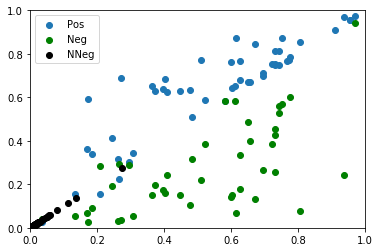

In [5]:
tester.cal_preds_in_training(tester,softmax(TE_tensor)[:,1].unsqueeze(1), bag_index_tensor, labels_tensor, epoch=50)

**********************1**********************
AUC: 0.9654652927515187
              precision    recall  f1-score   support

         0.0     0.9177    0.9741    0.9451      5138
         1.0     0.9092    0.7478    0.8206      1780

    accuracy                         0.9159      6918
   macro avg     0.9134    0.8609    0.8828      6918
weighted avg     0.9155    0.9159    0.9130      6918

[[5005  133]
 [ 449 1331]]


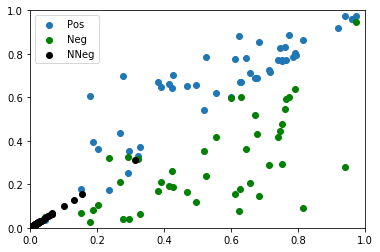

**********************2**********************
AUC: 0.9652274745124454
              precision    recall  f1-score   support

         0.0     0.9226    0.9702    0.9458      5138
         1.0     0.8990    0.7652    0.8267      1780

    accuracy                         0.9175      6918
   macro avg     0.9108    0.8677    0.8863      6918
weighted avg     0.9166    0.9175    0.9152      6918

[[4985  153]
 [ 418 1362]]


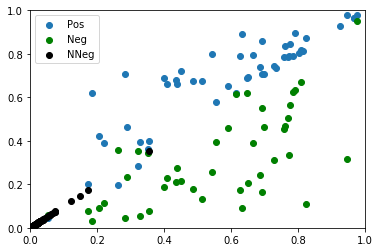

**********************3**********************
AUC: 0.9649163973215651
              precision    recall  f1-score   support

         0.0     0.9290    0.9648    0.9465      5138
         1.0     0.8856    0.7871    0.8334      1780

    accuracy                         0.9191      6918
   macro avg     0.9073    0.8759    0.8900      6918
weighted avg     0.9178    0.9191    0.9174      6918

[[4957  181]
 [ 379 1401]]


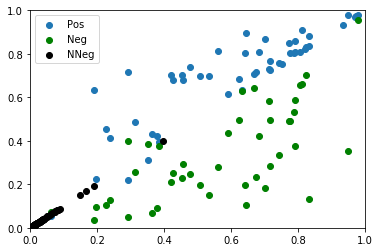

**********************4**********************
AUC: 0.9645405898329696
              precision    recall  f1-score   support

         0.0     0.9354    0.9580    0.9465      5138
         1.0     0.8696    0.8090    0.8382      1780

    accuracy                         0.9196      6918
   macro avg     0.9025    0.8835    0.8924      6918
weighted avg     0.9185    0.9196    0.9187      6918

[[4922  216]
 [ 340 1440]]


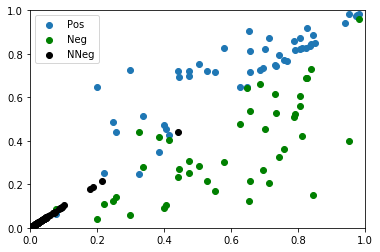

**********************5**********************
AUC: 0.9641328545623926
              precision    recall  f1-score   support

         0.0     0.9423    0.9511    0.9467      5138
         1.0     0.8551    0.8320    0.8434      1780

    accuracy                         0.9205      6918
   macro avg     0.8987    0.8916    0.8951      6918
weighted avg     0.9199    0.9205    0.9201      6918

[[4887  251]
 [ 299 1481]]


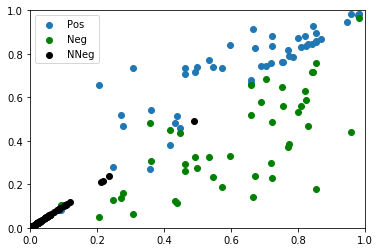

**********************6**********************
AUC: 0.9636493454804693
              precision    recall  f1-score   support

         0.0     0.9464    0.9447    0.9456      5138
         1.0     0.8413    0.8455    0.8434      1780

    accuracy                         0.9192      6918
   macro avg     0.8938    0.8951    0.8945      6918
weighted avg     0.9193    0.9192    0.9193      6918

[[4854  284]
 [ 275 1505]]


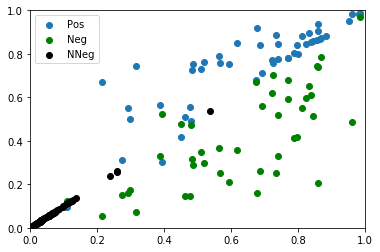

**********************7**********************
AUC: 0.9630663354341522
              precision    recall  f1-score   support

         0.0     0.9518    0.9348    0.9432      5138
         1.0     0.8210    0.8635    0.8417      1780

    accuracy                         0.9164      6918
   macro avg     0.8864    0.8991    0.8925      6918
weighted avg     0.9182    0.9164    0.9171      6918

[[4803  335]
 [ 243 1537]]


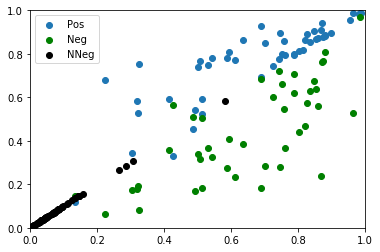

**********************8**********************
AUC: 0.9624252649349853
              precision    recall  f1-score   support

         0.0     0.9561    0.9231    0.9393      5138
         1.0     0.7982    0.8775    0.8360      1780

    accuracy                         0.9114      6918
   macro avg     0.8771    0.9003    0.8876      6918
weighted avg     0.9154    0.9114    0.9127      6918

[[4743  395]
 [ 218 1562]]


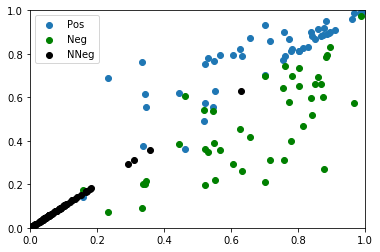

**********************9**********************
AUC: 0.9616863335972113
              precision    recall  f1-score   support

         0.0     0.9610    0.9064    0.9329      5138
         1.0     0.7679    0.8938    0.8261      1780

    accuracy                         0.9032      6918
   macro avg     0.8644    0.9001    0.8795      6918
weighted avg     0.9113    0.9032    0.9054      6918

[[4657  481]
 [ 189 1591]]


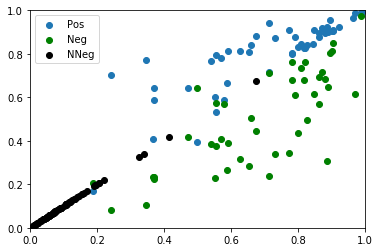

In [6]:
print('**********************1**********************')
tester.cal_preds_in_training(tester, softmax(TDE_a1_tensor)[:,1].unsqueeze(1), bag_index_tensor, labels_tensor, epoch=50)
print('**********************2**********************')
tester.cal_preds_in_training(tester, softmax(TDE_a2_tensor)[:,1].unsqueeze(1), bag_index_tensor, labels_tensor, epoch=50)
print('**********************3**********************')
tester.cal_preds_in_training(tester, softmax(TDE_a3_tensor)[:,1].unsqueeze(1), bag_index_tensor, labels_tensor, epoch=50)
print('**********************4**********************')
tester.cal_preds_in_training(tester, softmax(TDE_a4_tensor)[:,1].unsqueeze(1), bag_index_tensor, labels_tensor, epoch=50)
print('**********************5**********************')
tester.cal_preds_in_training(tester, softmax(TDE_a5_tensor)[:,1].unsqueeze(1), bag_index_tensor, labels_tensor, epoch=50)
print('**********************6**********************')
tester.cal_preds_in_training(tester, softmax(TDE_a6_tensor)[:,1].unsqueeze(1), bag_index_tensor, labels_tensor, epoch=50)
print('**********************7**********************')
tester.cal_preds_in_training(tester, softmax(TDE_a7_tensor)[:,1].unsqueeze(1), bag_index_tensor, labels_tensor, epoch=50)
print('**********************8**********************')
tester.cal_preds_in_training(tester, softmax(TDE_a8_tensor)[:,1].unsqueeze(1), bag_index_tensor, labels_tensor, epoch=50)
print('**********************9**********************')
tester.cal_preds_in_training(tester, softmax(TDE_a9_tensor)[:,1].unsqueeze(1), bag_index_tensor, labels_tensor, epoch=50)

AUC: 0.9658302754099221
              precision    recall  f1-score   support

         0.0     0.9854    0.7869    0.8750      5138
         1.0     0.6110    0.9663    0.7486      1780

    accuracy                         0.8330      6918
   macro avg     0.7982    0.8766    0.8118      6918
weighted avg     0.8891    0.8330    0.8425      6918

[[4043 1095]
 [  60 1720]]


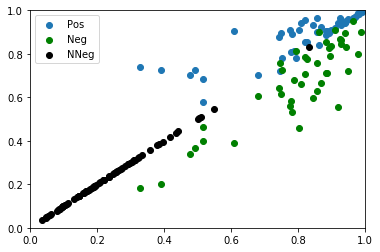

In [8]:
tester.cal_preds_in_training(tester, softmax(NDE_tensor)[:,1].unsqueeze(1), bag_index_tensor, labels_tensor, epoch=50)

AUC: 0.9654652927515188
              precision    recall  f1-score   support

         0.0     0.9177    0.9741    0.9451      5138
         1.0     0.9092    0.7478    0.8206      1780

    accuracy                         0.9159      6918
   macro avg     0.9134    0.8609    0.8828      6918
weighted avg     0.9155    0.9159    0.9130      6918

[[5005  133]
 [ 449 1331]]


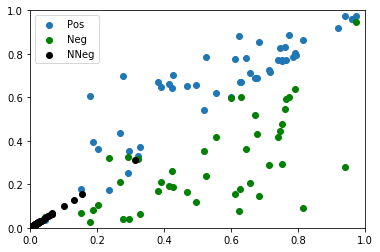

In [8]:
tester.cal_preds_in_training(tester, softmax(TE_tensor-0.1*NIE_tensor)[:,1].unsqueeze(1), bag_index_tensor, labels_tensor, epoch=50)

# NIE_tensor

In [10]:
(torch.argmax(softmax(preds_tensor),1)==labels_tensor).sum(),(labels_tensor).shape

NameError: name 'preds_tensor' is not defined

In [ ]:
(torch.argmax(softmax(preds_tensor),1)==torch.argmax(softmax(counter_preds_tensor),1)).sum()

In [ ]:
(torch.argmax(softmax(counter_preds_tensor),1)==labels_tensor).sum(),(labels_tensor).shape

In [ ]:
(torch.argmax(softmax(preds_tensor),1)[labels_tensor==1]).sum(), (labels_tensor==1).sum()

In [ ]:
, counter_preds_tensor[:20] , labels_tensor[:20]

In [ ]:
(labels_tensor==1).sum(), (labels_tensor==0).sum(),labels_tensor.shape

In [ ]:
bag_length = np.array(configs.trainset.bag_lengths)
plt.plot(np.sort(bag_length))
plt.plot(bag_length)

In [ ]:
bag_length.mean(),bag_length.std(),bag_length.min(),bag_length.max()

#### (preds_tensor<0).sum(), (counter_preds_tensor<0).sum(), (preds_tensor-0.1*counter_preds_tensor<0).sum()

In [ ]:
ins/Accuracy: 0.9009257755400357

ins/Precision: 0.8244067796610169

ins/Recall: 0.7760051052967454

ins/F1: 0.7994740302432609

ins/Specificity: 0.9435729847494554

ins/AUC: 0.9601778511872735
0=9673
0.01=.9673
0.1 =.9676
0.2=.9678
0.3=.968
0.4= .968
0.5=.9677
.8=.9635
1=.9419
2=.2545
3=.12
f01
-0.3 = 9735
0=9736
0.01= 
0.1 = 9735
.2 -9734
0.3 = 9732
0.4=.9727
.5 = .9718
1 = 7282
2=0.0358
f3 
0.1 .8862,.8209,.6746
0.5, .8945,.8219,.6851
1,.8756, .6884,.5805
counterfact can be used for f1 and AUC,by tuning 'a'

In [ ]:
torch.cat(attention_list).max(1).indices.histc(bins=10, min=0, max=9)

In [ ]:
vals = torch.cat(attention_list) #[N,10]
x = torch.cat(attention_list).max(1).indices
plt.plot(vals.mean(0).cpu().numpy()),plt.plot(vals.std(0).cpu().numpy())

In [ ]:
plt.plot(vals[x==1].mean(0).cpu().numpy()),plt.plot(vals[x==1].std(0).cpu().numpy())

### 下面是正负attention

In [ ]:
plt.plot(vals[labels_tensor==1].mean(0).cpu().numpy()),plt.plot(vals[labels_tensor==1].std(0).cpu().numpy())

In [ ]:
(labels_tensor==0).sum()

In [ ]:
plt.plot(vals[labels_tensor==0].mean(0).cpu().numpy()),plt.plot(vals[labels_tensor==0].std(0).cpu().numpy())

In [ ]:
((labels_tensor==1)&(x.cpu()==1)).sum(), (labels_tensor==1).sum()

In [ ]:
((labels_tensor==0)&(x.cpu()==5)).sum(), (labels_tensor==0).sum()

In [ ]:
(labels_tensor==1).sum(), (x.cpu()==5).sum()

In [ ]:
print(vals[x==1].shape)
plt.plot(vals[x==1].mean(0).cpu().numpy()),plt.plot(vals[x==1].std(0).cpu().numpy())

In [ ]:
plt.plot(torch.cat(attention_list).mean(0).cpu().numpy())

In [ ]:
feature_list, bag_idx_list, inner_idx_list = trainer.eval(trainer, configs.load, configs.valset)
features = torch.cat(feature_list)
bag_indexs = torch.cat(bag_idx_list).unsqueeze(-1).float().cuda()
inner_indexs = torch.cat(inner_idx_list).unsqueeze(-1).float().cuda()
confounderSet = torch.cat((features, bag_indexs, inner_indexs),dim=1)

# import numpy as np
# confounder = np.array(confounderSet.cpu())
# if not os.path.exists(args.save_path):
#     os.makedirs(args.save_path)
# np.save(args.log_dir+'/conf.npy', confounder)

In [ ]:
dic = torch.tensor(np.load(os.path.join(configs.load_path, 'conf.npy')), dtype=torch.float)
feature = dic[:, :-2]
bag_num = dic[:, -2:-1].max()
conf_list = [feature[(dic[:, -2:-1]==num).squeeze(1)].mean(axis=0) for num in range(int(bag_num+1))]

In [ ]:
dic[(dic[:, -2:-1]==0).squeeze(1)].mean(axis=0).shape

In [ ]:
plt.plot(torch.stack(conf_list).std(0))

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
fitter = TSNE()
conf_tsne = fitter.fit_transform(torch.stack(conf_list))
conf_tsne.shape

In [ ]:
plt.scatter(*zip(*conf_tsne))

In [ ]:
def l2_normalize(tensor):
    norm = tensor.norm(p=2, dim=1).unsqueeze(-1)
    return tensor.div(norm.expand_as(tensor))

In [ ]:
fitter1 = TSNE()
conf_tsne = fitter1.fit_transform(l2_normalize(torch.stack(conf_list)))
conf_tsne.shape

In [ ]:
plt.scatter(*zip(*conf_tsne))

In [ ]:
a = torch.randn(2,10).softmax(1)
a

In [ ]:
sorted_a, indices = torch.sort(a,descending=True)
sorted_a, indices 

In [ ]:
sorted_a_sum = torch.cumsum(sorted_a, dim=1)
sorted_a_sum

In [ ]:
mask = sorted_a_sum>=0.65
mask

In [ ]:
sorted_a[mask] = -1000
sorted_a

In [ ]:
chunk_sorted_a = sorted_a.softmax(dim=1)
chunk_sorted_a, chunk_sorted_a.shape

In [ ]:
indices

In [ ]:
confounded = torch.arange(10*512).view(10, 512)
confounded

In [ ]:
reorder_confounded = confounded[indices]

In [ ]:
reorder_confounded.shape, chunk_sorted_a.shape

In [ ]:
z = (reorder_confounded * chunk_sorted_a.unsqueeze(-1)).sum(dim=1)
z.shape

In [ ]:
torch.bmm(chunk_sorted_a.unsqueeze(1), reorder_confounded.float())

In [ ]:
torch.einsum('bmc,bm->bc', ).contiguous()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

path = 'sftp://root@192.168.4.97:20028/remote-home/share/DATA/HISMIL/5_folder/0/train/pos/18_00991B_2019-05-07 2021_27_54-lv1-16174-30030-3538-5736'
# 设置matplotlib正常显示中文和负号
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号
# 随机生成（10000,）服从正态分布的数据
data = np.random.randn(10000)
"""
绘制直方图
data:必选参数，绘图数据
bins:直方图的长条形数目，可选项，默认为10
normed:是否将得到的直方图向量归一化，可选项，默认为0，代表不归一化，显示频数。normed=1，表示归一化，显示频率。
facecolor:长条形的颜色
edgecolor:长条形边框的颜色
alpha:透明度
"""
plt.hist(data, bins=40, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("Hi")
# 显示纵轴标签
plt.ylabel("Intensity")
# 显示图标题
plt.title("Try1Try")
plt.show()
